# Random Forest

## Import Libraries and Set Up Environment

In [14]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
import shap
import joblib
import warnings
warnings.filterwarnings('ignore')

OUTPUT_DIR = "output/modeling_new"
os.makedirs(OUTPUT_DIR, exist_ok=True)


## Load and Preview Data

In [15]:
df = pd.read_csv('processed_data/ct_integrated_data.csv')
df = df.drop(columns=['Pop15t19', 'Pop20t24', 'Pop25t29'])

print("Missing value statistics:")
print(df.isnull().sum())

print("\nBasic statistical description:")
print(df.describe())

print("\nData types overview:")
print(df.dtypes)


Missing value statistics:
GEOID                                  0
Total_Population                       0
Pop15t29                               0
NAME                                   1
income_level                           1
geometry                               0
area_sqkm                              0
population_density                     0
youth_population_pct                   0
station_count                          0
station_density                        0
avg_ridership                          0
transfer_station_ratio                 0
avg_entrances                          0
station_coverage                       0
annual_total_crime_density             0
annual_property_crime_density          0
annual_violent_crime_density           0
poi_density_Transportation Facility    0
poi_density_Recreational Facility      0
poi_density_Education Facility         0
poi_density_Residential                0
poi_density_Social Services            0
poi_density_Religious Instituti

## Handle Missing Values

In [16]:
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
if df[numeric_cols].isnull().any().any():
    for col in numeric_cols:
        df[col] = df[col].fillna(df[col].mean())

non_numeric_cols = df.select_dtypes(exclude=['float64', 'int64']).columns
for col in non_numeric_cols:
    if col != 'geometry':
        df[col] = df[col].fillna(df[col].mode()[0] if len(df[col].mode()) > 0 else 'Unknown')


## Select Features and Standardize Data

In [17]:
target_vars = ['annual_total_crime_density', 'annual_property_crime_density', 'annual_violent_crime_density']
features = [
    'station_density', 'station_coverage', 'avg_ridership', 'transfer_station_ratio', 'avg_entrances',
    'income_level', 'poverty_rate', 'population_density', 
    'youth_population_pct', 'road_density', 'neighboring_crime_density',
    'poi_density_Transportation Facility', 'poi_density_Recreational Facility',
    'poi_density_Education Facility', 'poi_density_Residential',
    'poi_density_Social Services', 'poi_density_Religious Institution',
    'poi_density_Cultural Facility', 'poi_density_Public Safety',
    'poi_density_Commercial', 'poi_density_Government Facility',
    'poi_density_Health Services'
]

features = [f for f in features if f in df.columns]
X = df[features]
y_total, y_property, y_violent = df[target_vars[0]], df[target_vars[1]], df[target_vars[2]]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=features)


## Split Data into Training and Test Sets

In [18]:
X_train, X_test, y_total_train, y_total_test = train_test_split(X_scaled_df, y_total, test_size=0.3, random_state=42)
_, _, y_property_train, y_property_test = train_test_split(X_scaled_df, y_property, test_size=0.3, random_state=42)
_, _, y_violent_train, y_violent_test = train_test_split(X_scaled_df, y_violent, test_size=0.3, random_state=42)


## Define and Train Random Forest Models

In [19]:
def optimize_rf_model(X_train, y_train, X_test, y_test, name):
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 15, 25, 35],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2', None],
        'bootstrap': [True, False]
    }

    rf = RandomForestRegressor(random_state=42)

    grid_search = GridSearchCV(
        estimator=rf,
        param_grid=param_grid,
        cv=5,
        n_jobs=-1,
        scoring='neg_mean_squared_error',
        verbose=1
    )

    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_
    best_rf = grid_search.best_estimator_
    y_pred = best_rf.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    cv_scores = cross_val_score(best_rf, X_train, y_train, cv=5, scoring='r2')

    with open(os.path.join(OUTPUT_DIR, f"{name}_model_results.txt"), 'w') as f:
        f.write(f"Best parameters: {best_params}\n")
        f.write(f"MSE: {mse:.4f}\n")
        f.write(f"RMSE: {rmse:.4f}\n")
        f.write(f"R²: {r2:.4f}\n")
        f.write(f"Cross-validation R² scores: {cv_scores}\n")
        f.write(f"Mean cross-validation R²: {np.mean(cv_scores):.4f}\n")

    return best_rf, y_pred


total_model, total_pred = optimize_rf_model(X_train, y_total_train, X_test, y_total_test, "total_crime_density")
property_model, property_pred = optimize_rf_model(X_train, y_property_train, X_test, y_property_test, "property_crime_density")
violent_model, violent_pred = optimize_rf_model(X_train, y_violent_train, X_test, y_violent_test, "violent_crime_density")


Fitting 5 folds for each of 648 candidates, totalling 3240 fits
Fitting 5 folds for each of 648 candidates, totalling 3240 fits
Fitting 5 folds for each of 648 candidates, totalling 3240 fits


## Plot Feature Importance

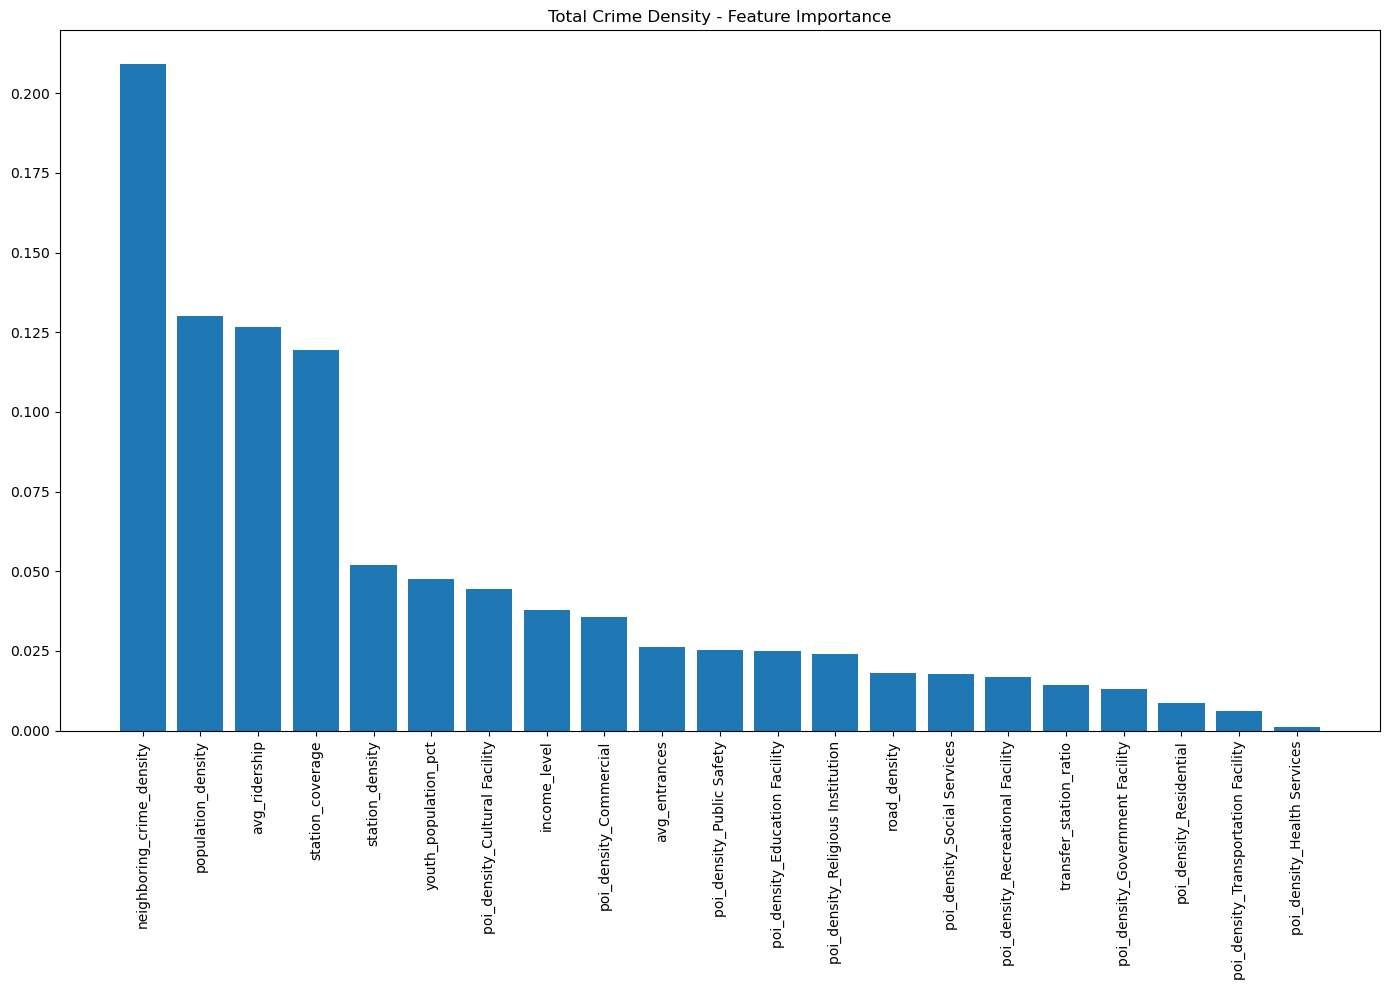

neighboring_crime_density: 0.2093
population_density: 0.1301
avg_ridership: 0.1267
station_coverage: 0.1195
station_density: 0.0518
youth_population_pct: 0.0477
poi_density_Cultural Facility: 0.0443
income_level: 0.0379
poi_density_Commercial: 0.0355
avg_entrances: 0.0263
poi_density_Public Safety: 0.0252
poi_density_Education Facility: 0.0249
poi_density_Religious Institution: 0.0242
road_density: 0.0182
poi_density_Social Services: 0.0178
poi_density_Recreational Facility: 0.0170
transfer_station_ratio: 0.0143
poi_density_Government Facility: 0.0132
poi_density_Residential: 0.0087
poi_density_Transportation Facility: 0.0062
poi_density_Health Services: 0.0010


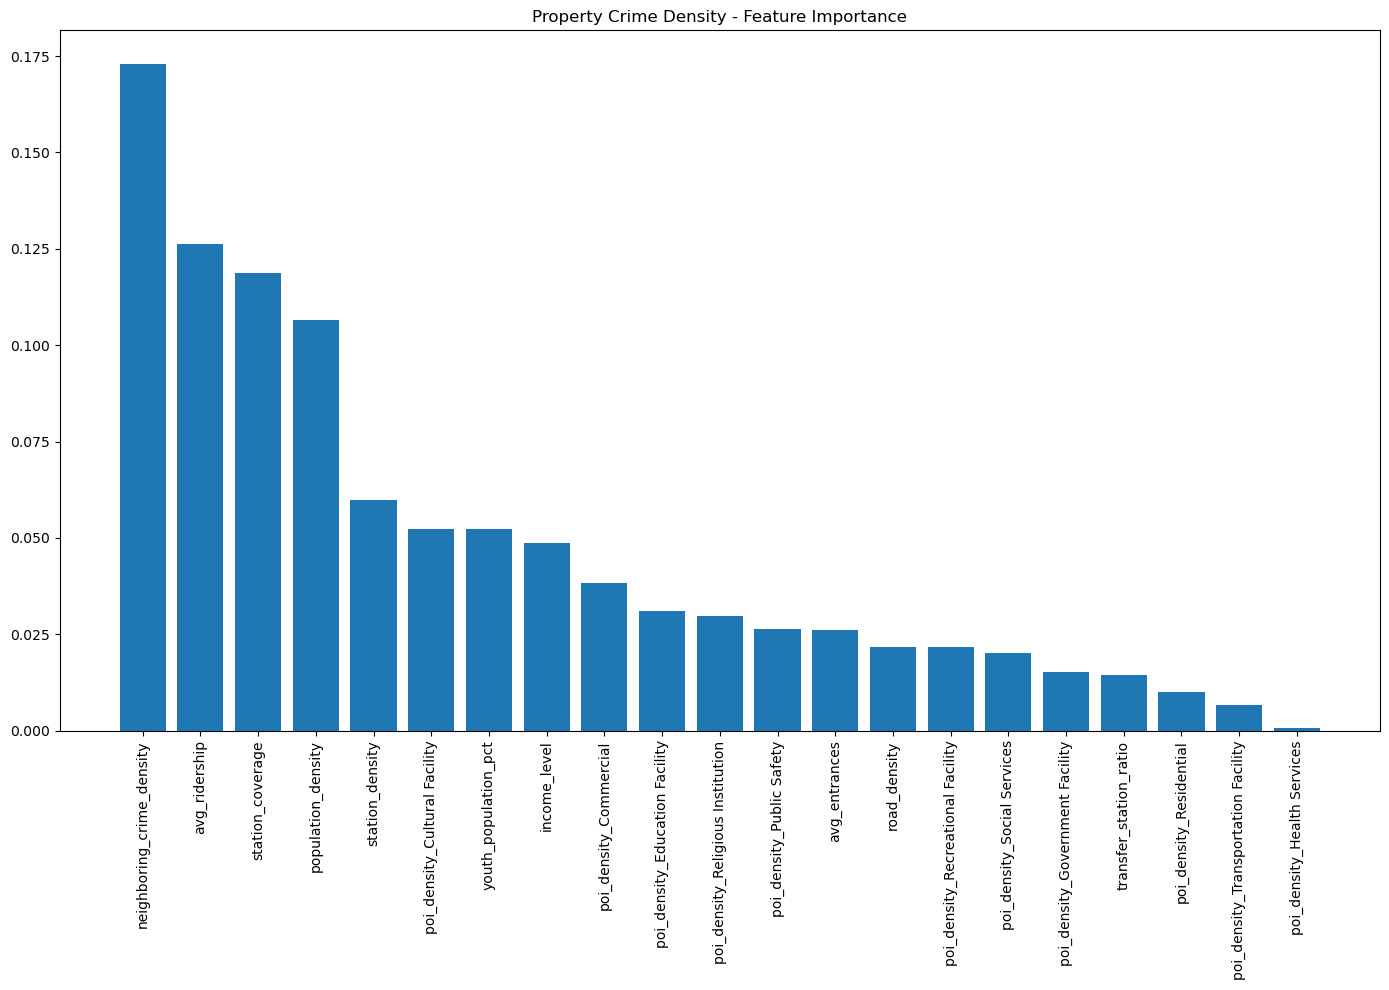

neighboring_crime_density: 0.1730
avg_ridership: 0.1264
station_coverage: 0.1188
population_density: 0.1065
station_density: 0.0599
poi_density_Cultural Facility: 0.0524
youth_population_pct: 0.0522
income_level: 0.0486
poi_density_Commercial: 0.0383
poi_density_Education Facility: 0.0311
poi_density_Religious Institution: 0.0297
poi_density_Public Safety: 0.0263
avg_entrances: 0.0260
road_density: 0.0217
poi_density_Recreational Facility: 0.0216
poi_density_Social Services: 0.0203
poi_density_Government Facility: 0.0151
transfer_station_ratio: 0.0144
poi_density_Residential: 0.0101
poi_density_Transportation Facility: 0.0067
poi_density_Health Services: 0.0008


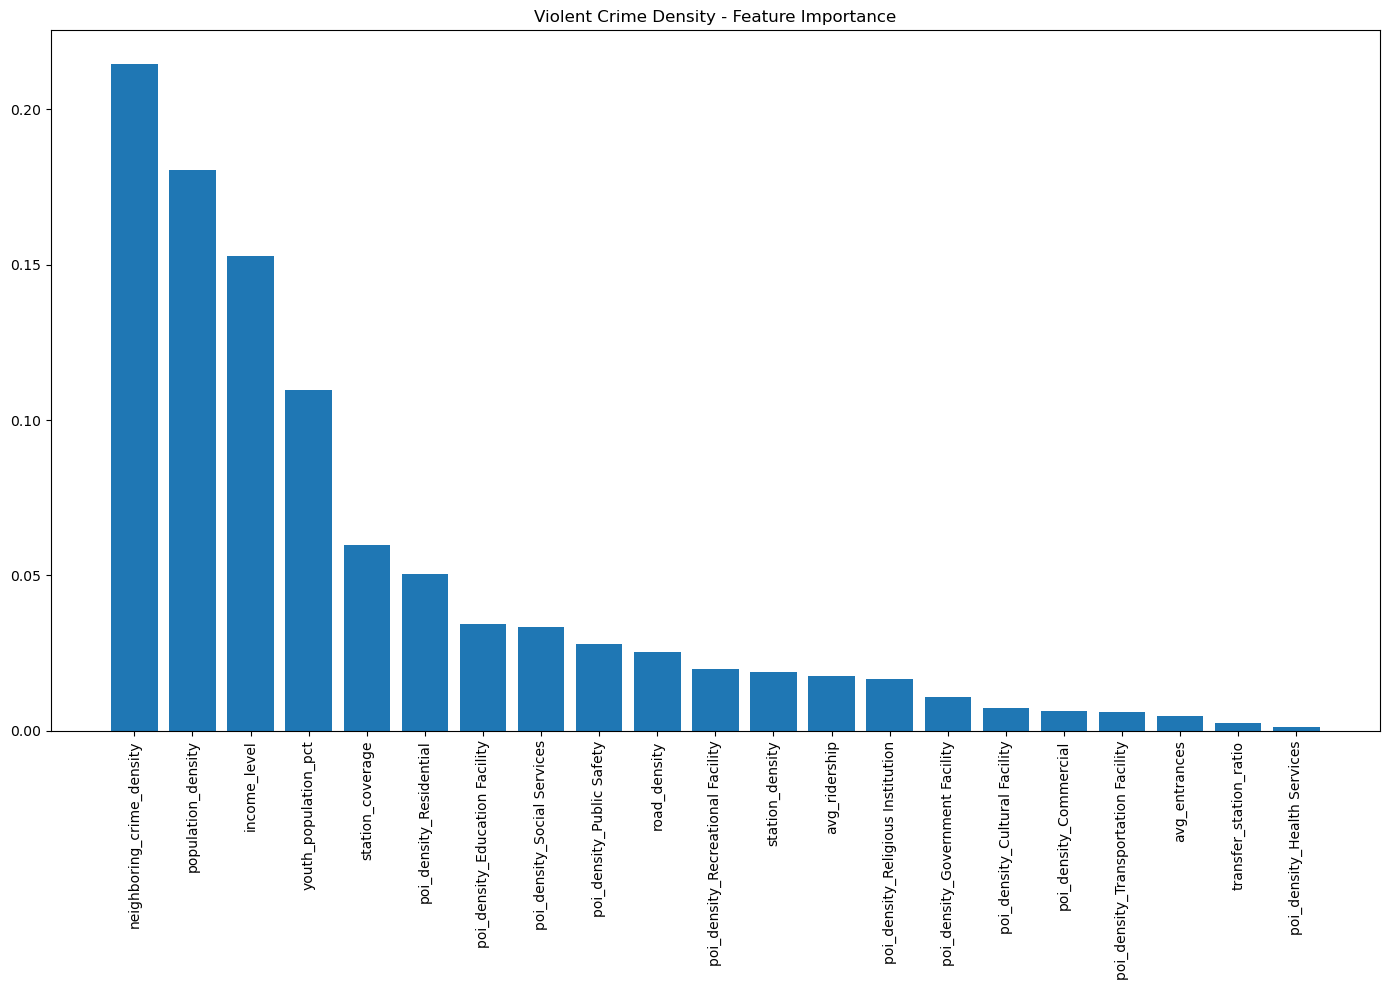

neighboring_crime_density: 0.2147
population_density: 0.1806
income_level: 0.1527
youth_population_pct: 0.1095
station_coverage: 0.0598
poi_density_Residential: 0.0503
poi_density_Education Facility: 0.0344
poi_density_Social Services: 0.0334
poi_density_Public Safety: 0.0278
road_density: 0.0252
poi_density_Recreational Facility: 0.0199
station_density: 0.0188
avg_ridership: 0.0175
poi_density_Religious Institution: 0.0166
poi_density_Government Facility: 0.0109
poi_density_Cultural Facility: 0.0074
poi_density_Commercial: 0.0062
poi_density_Transportation Facility: 0.0059
avg_entrances: 0.0048
transfer_station_ratio: 0.0023
poi_density_Health Services: 0.0013


(array([ 9,  6,  5,  7,  1, 13, 12, 14, 17,  8, 11,  0,  2, 15, 19, 16, 18,
        10,  4,  3, 20]),
 array([0.01875201, 0.05980493, 0.01748622, 0.00231368, 0.00478772,
        0.15270138, 0.18060876, 0.10954318, 0.02520434, 0.21470122,
        0.00587508, 0.01992036, 0.03442144, 0.05031156, 0.03344101,
        0.01656048, 0.00740806, 0.02780948, 0.00618353, 0.01085054,
        0.001315  ]))

In [20]:
def plot_feature_importance(model, feature_names, title):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(14, 10))
    plt.title(title)
    plt.bar(range(len(importances)), importances[indices], align='center')
    plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, f"{title.replace(' - ', '_').replace(' ', '_')}.png"), dpi=300)
    plt.show()

    with open(os.path.join(OUTPUT_DIR, f"{title.replace(' - ', '_').replace(' ', '_')}_importance.txt"), 'w') as f:
        for i in indices:
            importance_str = f"{feature_names[i]}: {importances[i]:.4f}"
            print(importance_str)
            f.write(importance_str + "\n")

    return indices, importances


plot_feature_importance(total_model, features, "Total Crime Density - Feature Importance")
plot_feature_importance(property_model, features, "Property Crime Density - Feature Importance")
plot_feature_importance(violent_model, features, "Violent Crime Density - Feature Importance")


## Compare Feature Importance Between Crime Types


特征重要性差异比较（财产犯罪 vs 暴力犯罪）:
Model                                Property Crime Density  \
Feature                                                       
avg_ridership                                      0.126389   
station_coverage                                   0.118779   
poi_density_Cultural Facility                      0.052438   
station_density                                    0.059907   
poi_density_Commercial                             0.038306   
avg_entrances                                      0.026036   
poi_density_Religious Institution                  0.029682   
transfer_station_ratio                             0.014394   
poi_density_Government Facility                    0.015094   
poi_density_Recreational Facility                  0.021604   
poi_density_Transportation Facility                0.006714   
poi_density_Health Services                        0.000814   
poi_density_Public Safety                          0.026320   
poi_density_Education Facilit

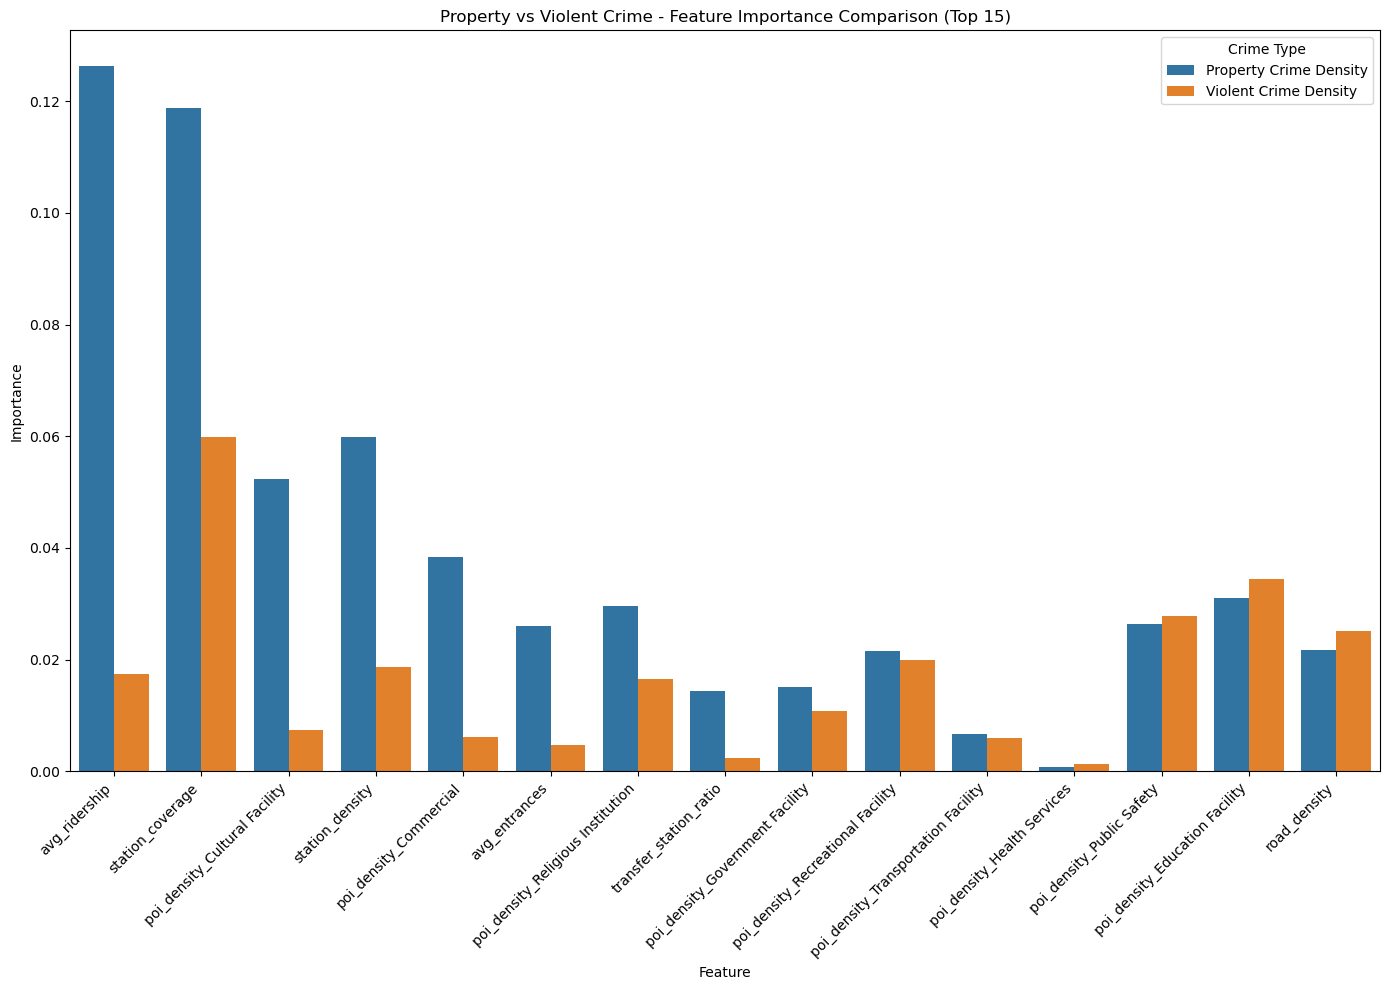

In [21]:
def compare_feature_importance(models, feature_names, model_names):
    importance_data = []

    for model, name in zip(models, model_names):
        importances = model.feature_importances_
        for i, feature in enumerate(feature_names):
            importance_data.append({
                'Model': name,
                'Feature': feature,
                'Importance': importances[i]
            })

    importance_df = pd.DataFrame(importance_data)
    pivot_df = importance_df.pivot(index='Feature', columns='Model', values='Importance')
    pivot_df['Property-Violent_Diff'] = pivot_df[model_names[1]] - pivot_df[model_names[2]]
    sorted_pivot = pivot_df.sort_values(by='Property-Violent_Diff', ascending=False)
    print("\n特征重要性差异比较（财产犯罪 vs 暴力犯罪）:")
    print(sorted_pivot)
    sorted_pivot.to_csv(os.path.join(OUTPUT_DIR, "crime_type_importance_comparison.csv"))

    plt.figure(figsize=(14, 10))
    top_features = sorted_pivot.head(15).index
    plot_data = []

    for feature in top_features:
        for model_name in model_names[1:3]:
            plot_data.append({
                'Feature': feature,
                'Model': model_name,
                'Importance': sorted_pivot.loc[feature, model_name]
            })

    plot_df = pd.DataFrame(plot_data)
    ax = sns.barplot(x='Feature', y='Importance', hue='Model', data=plot_df)
    plt.title("Property vs Violent Crime - Feature Importance Comparison (Top 15)")
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Crime Type')
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, "crime_type_importance_comparison.png"), dpi=300)
    plt.show()


model_names = ['Total Crime Density', 'Property Crime Density', 'Violent Crime Density']
models = [total_model, property_model, violent_model]
compare_feature_importance(models, features, model_names)


## Analyze SHAP Values

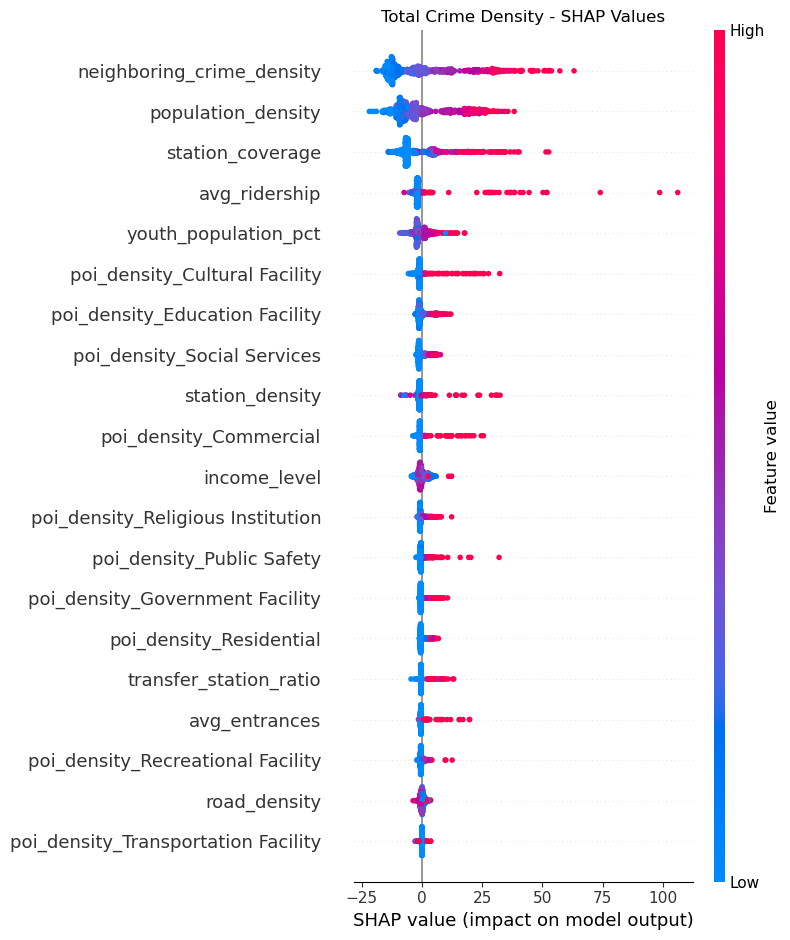

<Figure size 1200x800 with 0 Axes>

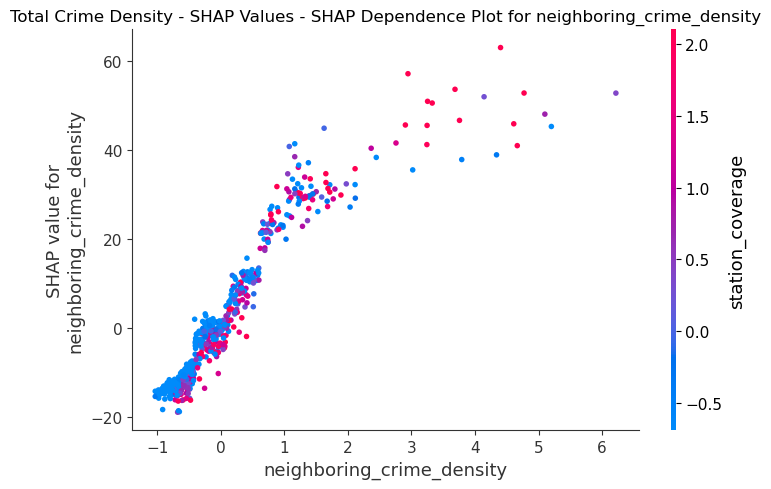

<Figure size 1200x800 with 0 Axes>

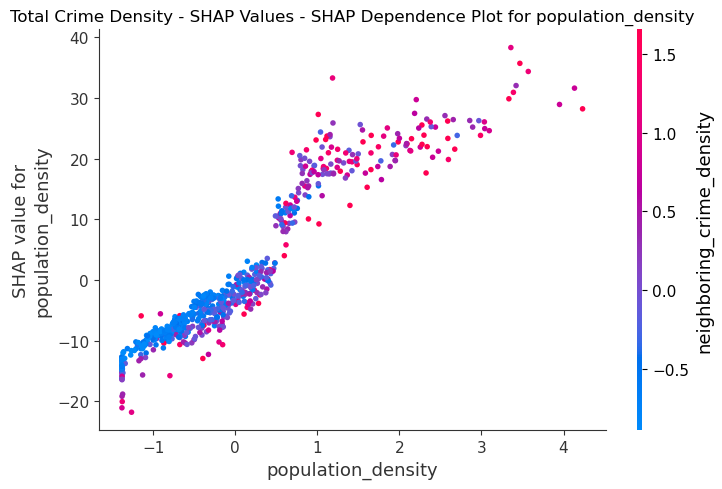

<Figure size 1200x800 with 0 Axes>

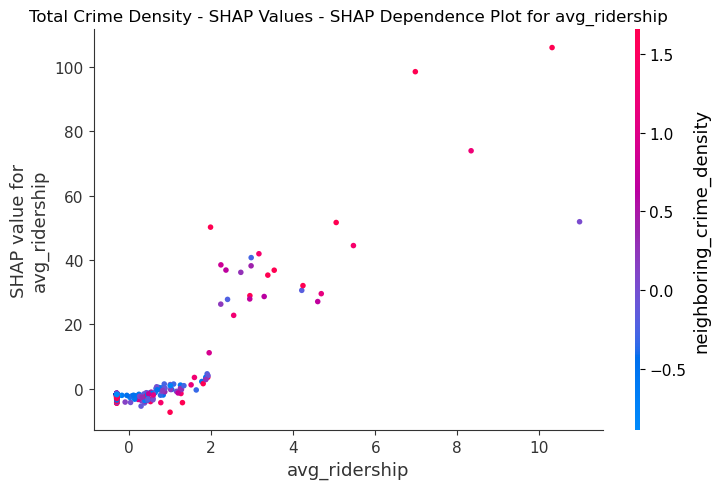

<Figure size 1200x800 with 0 Axes>

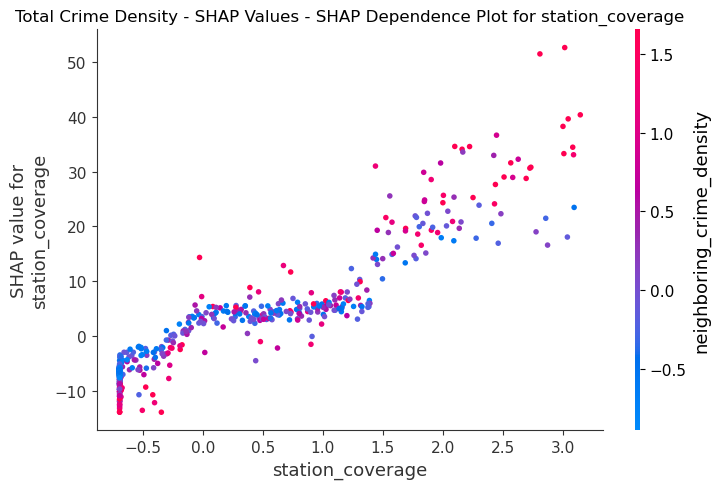

<Figure size 1200x800 with 0 Axes>

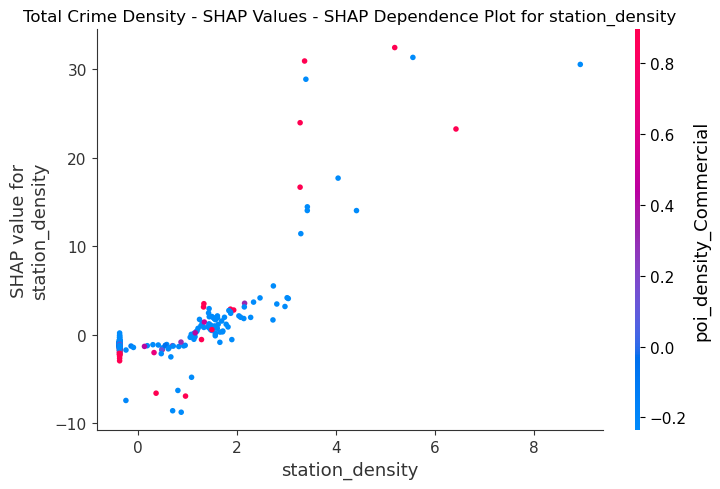

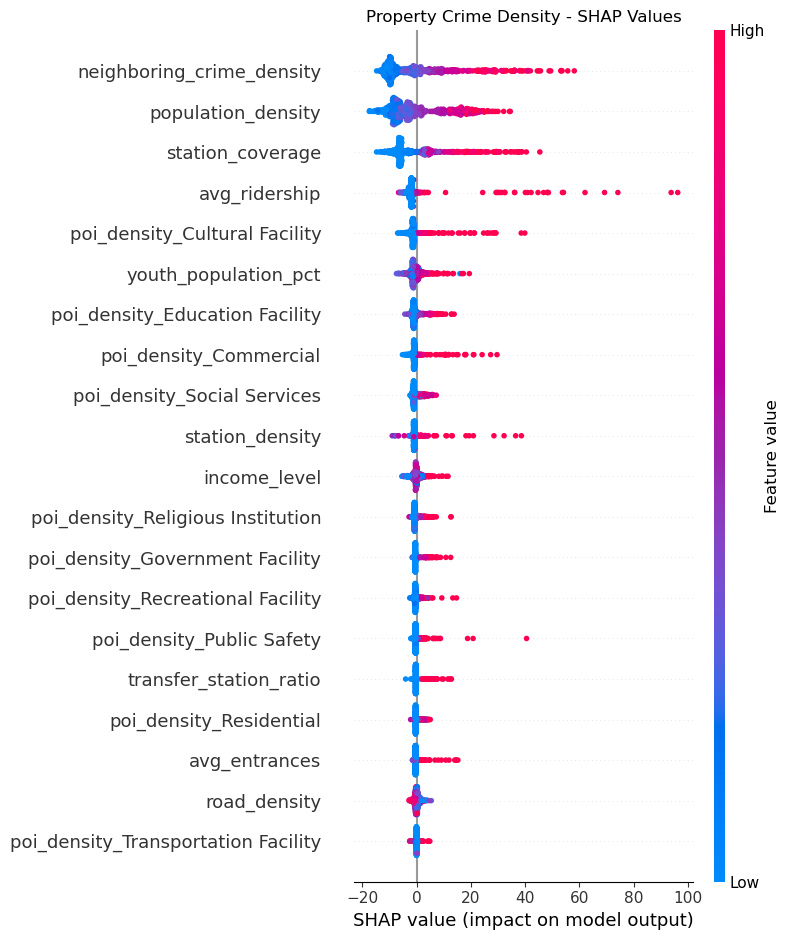

<Figure size 1200x800 with 0 Axes>

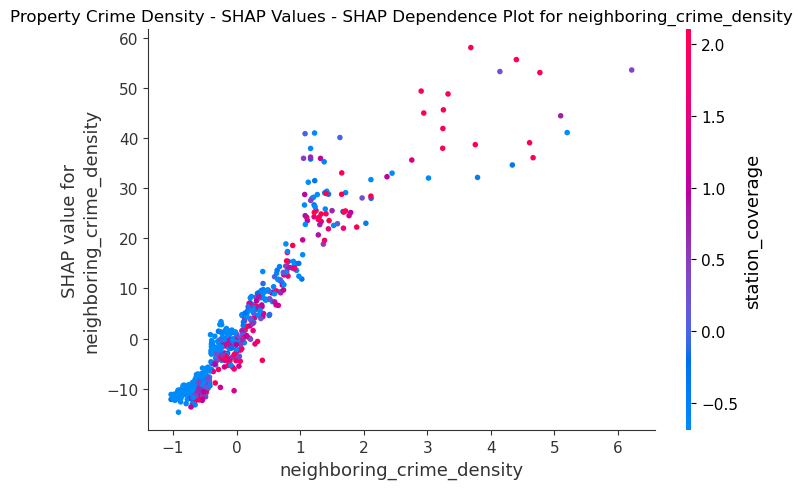

<Figure size 1200x800 with 0 Axes>

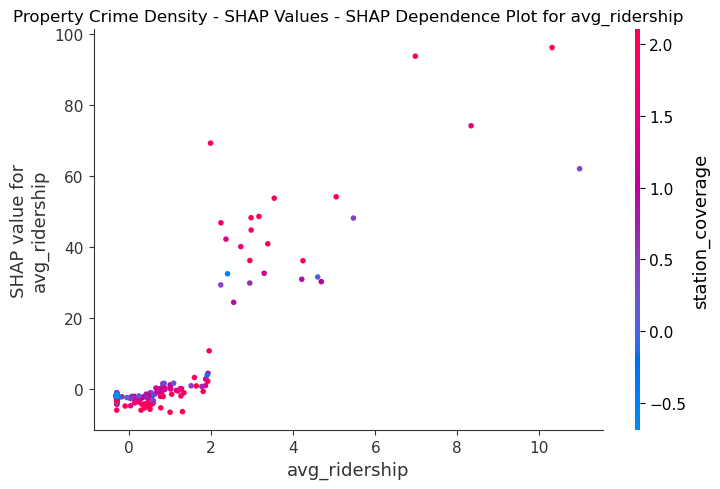

<Figure size 1200x800 with 0 Axes>

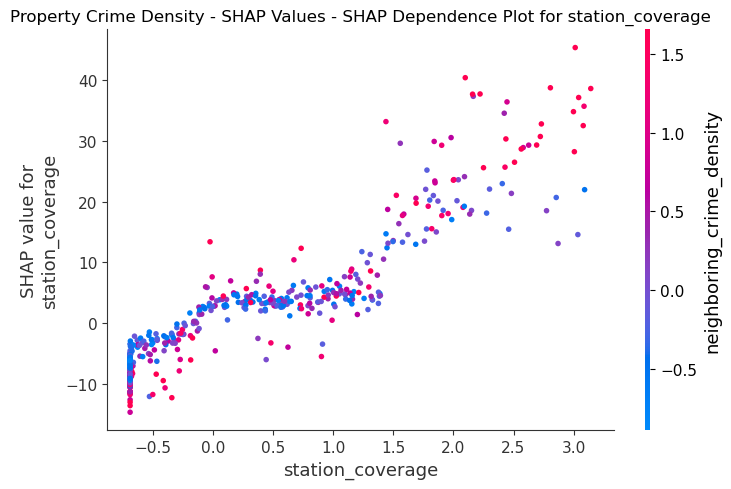

<Figure size 1200x800 with 0 Axes>

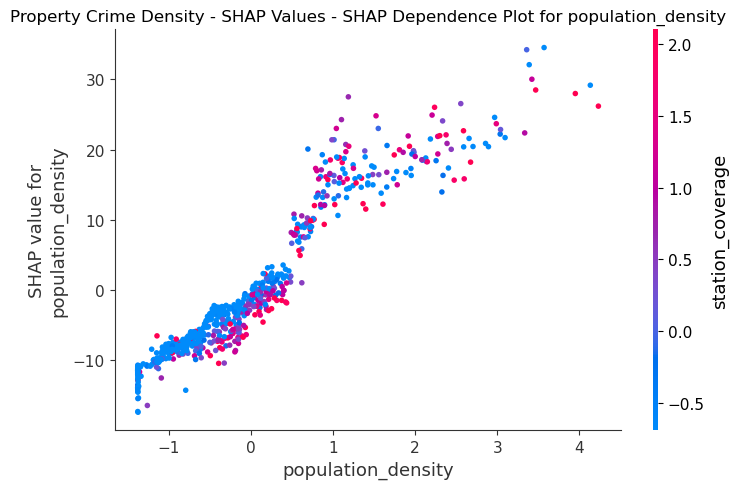

<Figure size 1200x800 with 0 Axes>

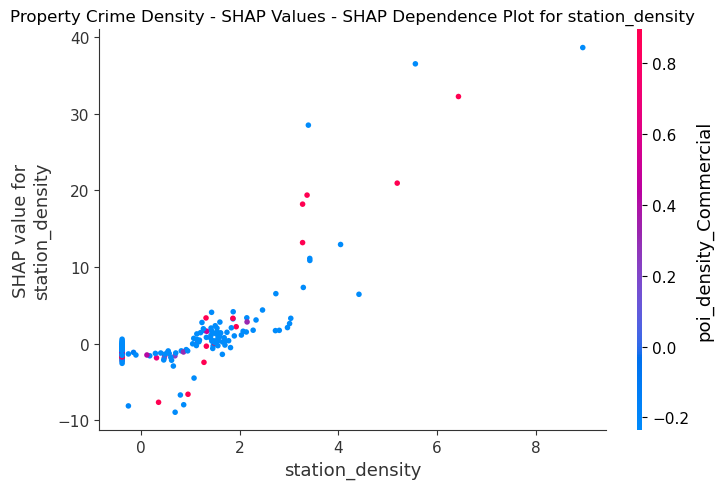

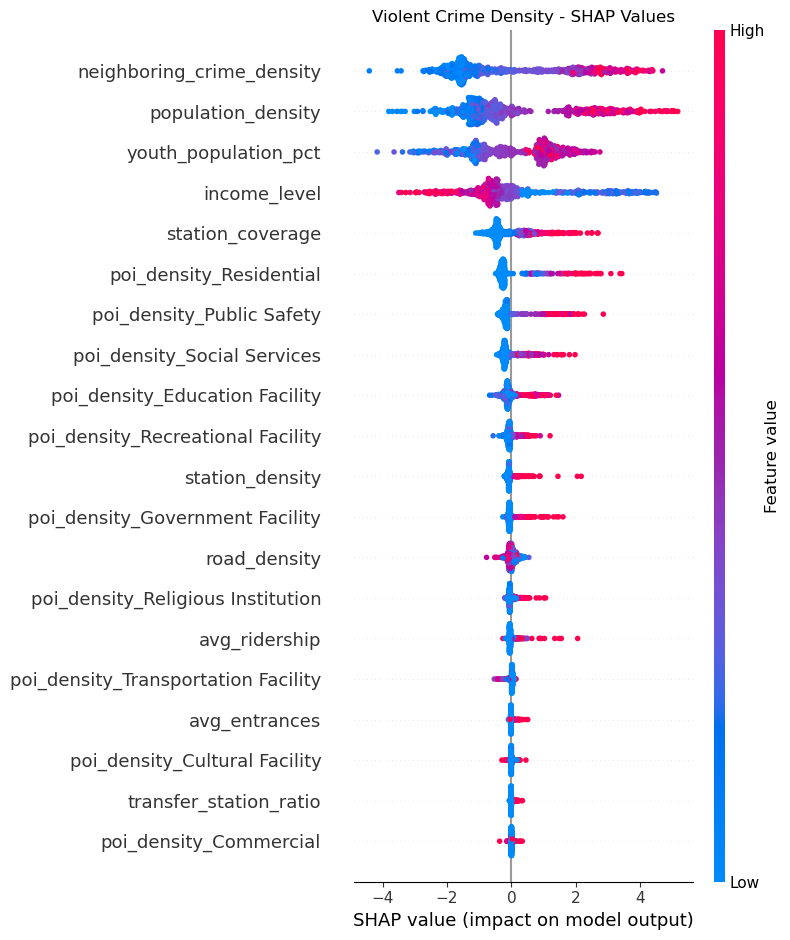

<Figure size 1200x800 with 0 Axes>

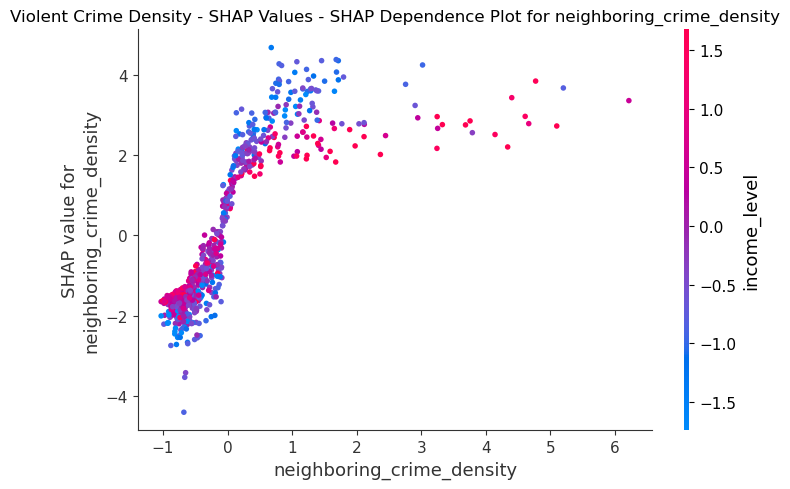

<Figure size 1200x800 with 0 Axes>

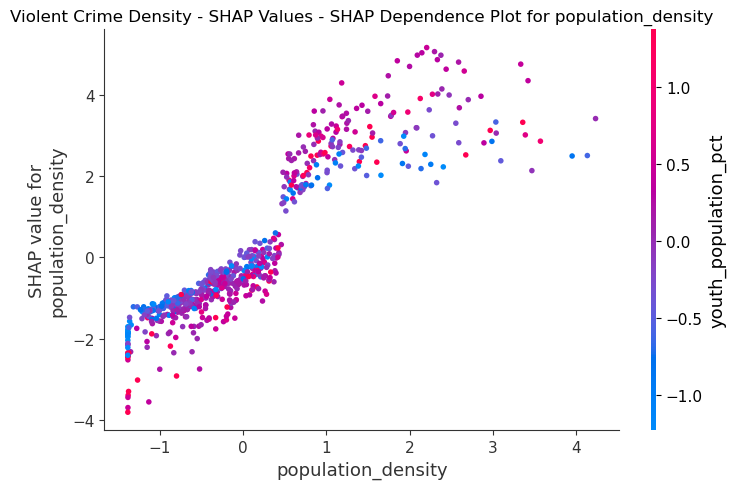

<Figure size 1200x800 with 0 Axes>

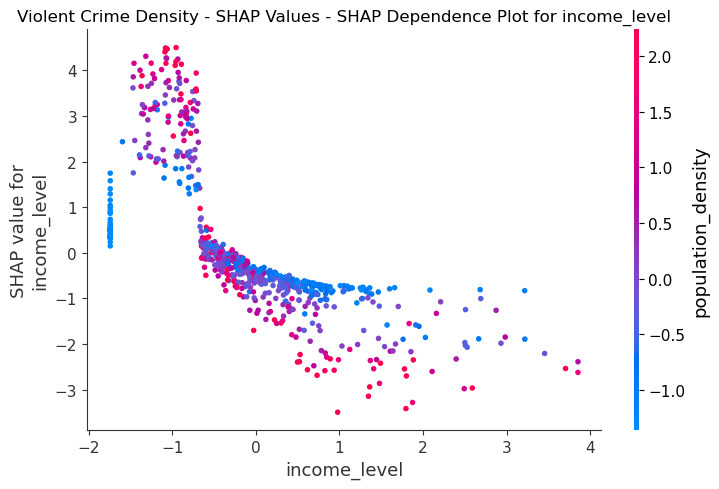

<Figure size 1200x800 with 0 Axes>

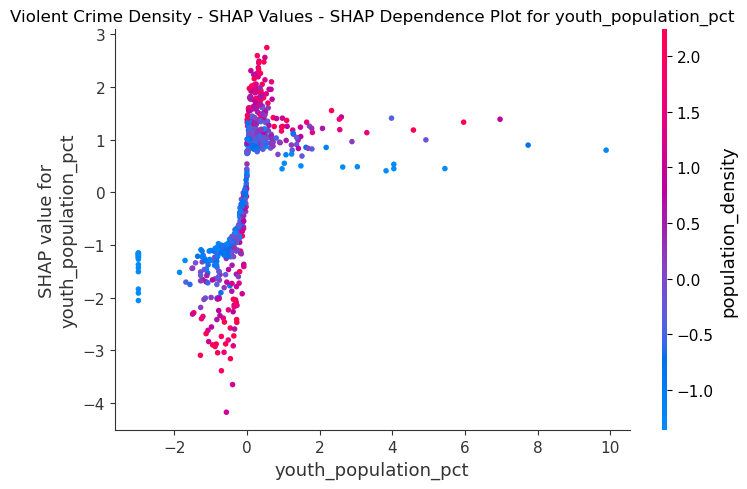

<Figure size 1200x800 with 0 Axes>

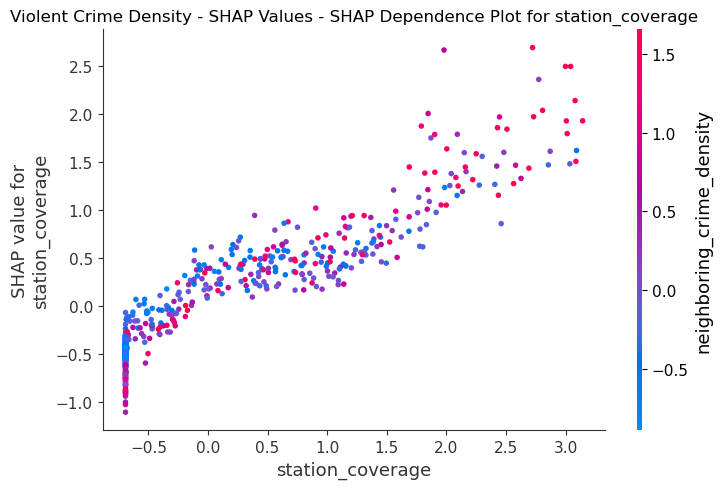

In [22]:
def analyze_shap_values(model, X_test, feature_names, title):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)

    plt.figure(figsize=(12, 12))
    shap.summary_plot(shap_values, X_test, feature_names=feature_names, show=False)
    plt.title(title)
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, f"{title.replace(' - ', '_').replace(' ', '_')}_shap_summary.png"), dpi=300)
    plt.show()

    top_indices = np.argsort(model.feature_importances_)[::-1][:5]
    top_features = [feature_names[i] for i in top_indices]

    for feature in top_features:
        plt.figure(figsize=(12, 8))
        shap.dependence_plot(feature, shap_values, X_test, feature_names=feature_names, show=False)
        plt.title(f"{title} - SHAP Dependence Plot for {feature}")
        plt.tight_layout()
        plt.savefig(os.path.join(OUTPUT_DIR, f"{title.replace(' - ', '_').replace(' ', '_')}_{feature.replace(' ', '_')}_dependence.png"), dpi=300)
        plt.show()


analyze_shap_values(total_model, X_test, features, "Total Crime Density - SHAP Values")
analyze_shap_values(property_model, X_test, features, "Property Crime Density - SHAP Values")
analyze_shap_values(violent_model, X_test, features, "Violent Crime Density - SHAP Values")


## Plot Predictions vs Actual and Residuals

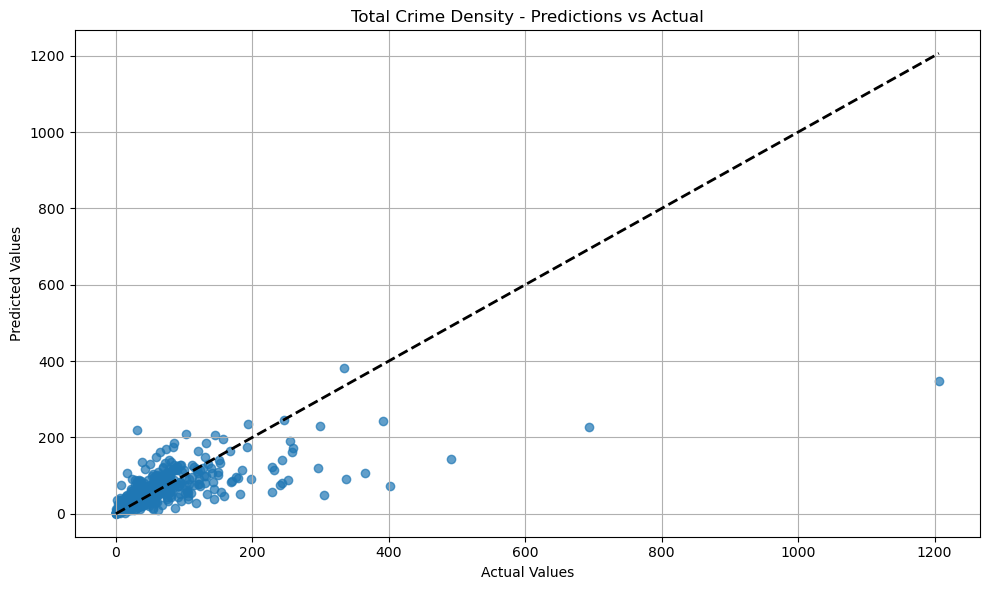

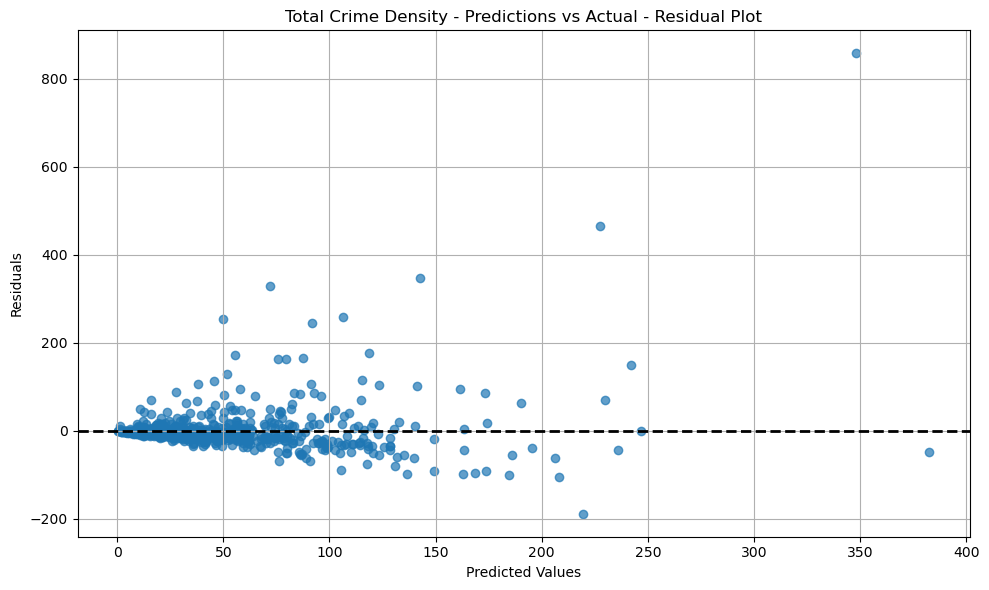

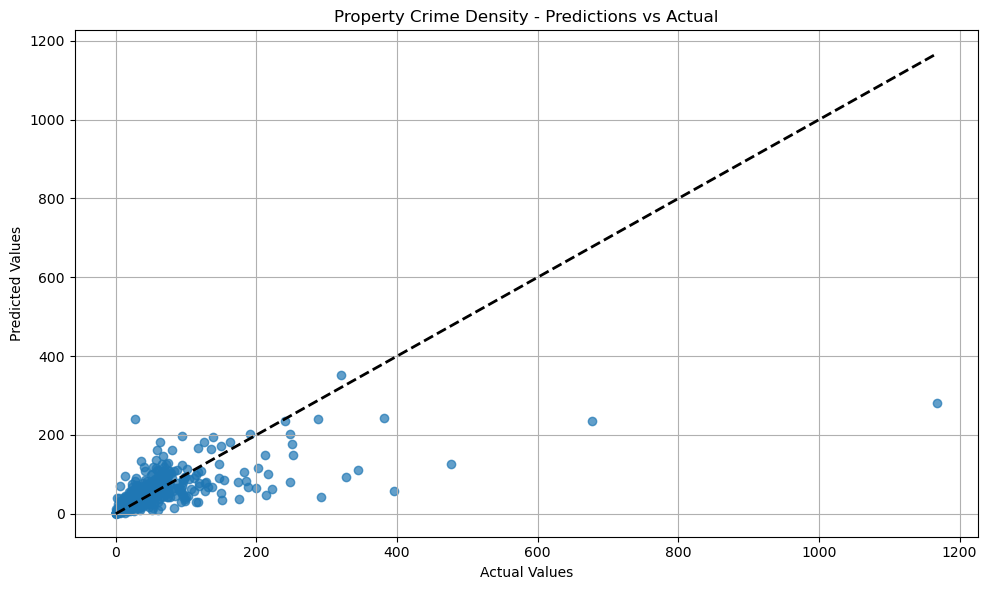

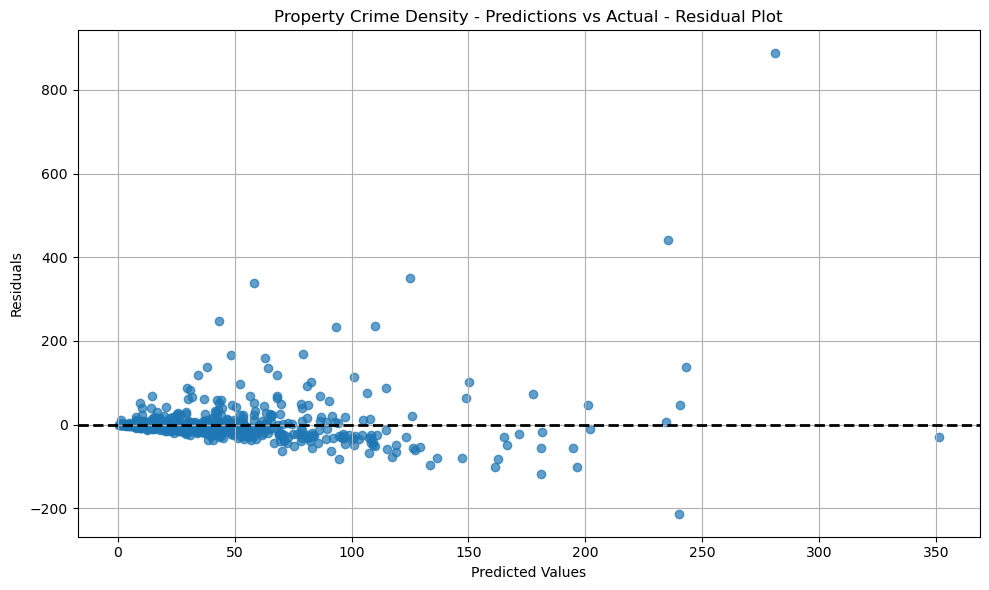

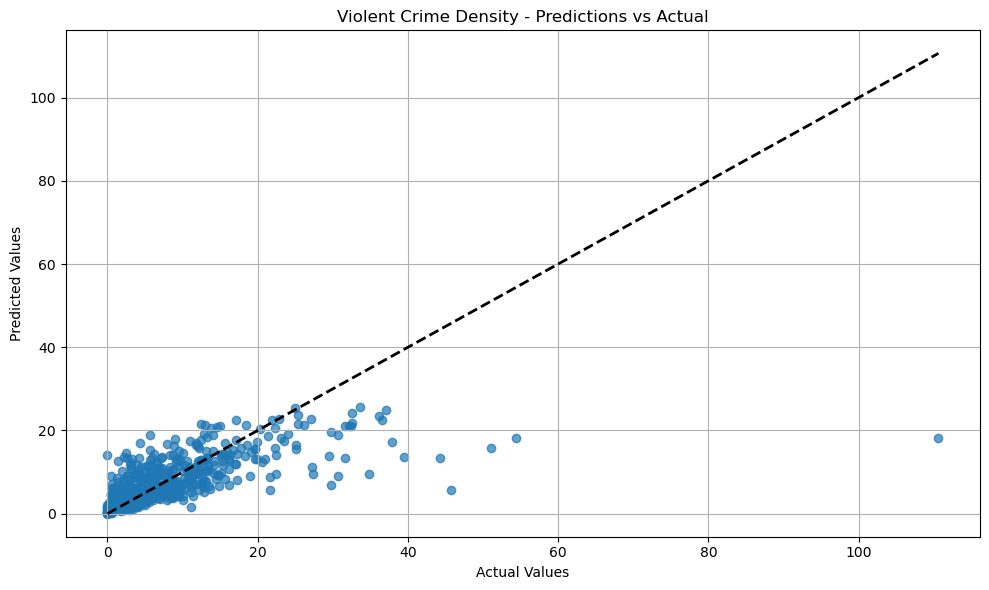

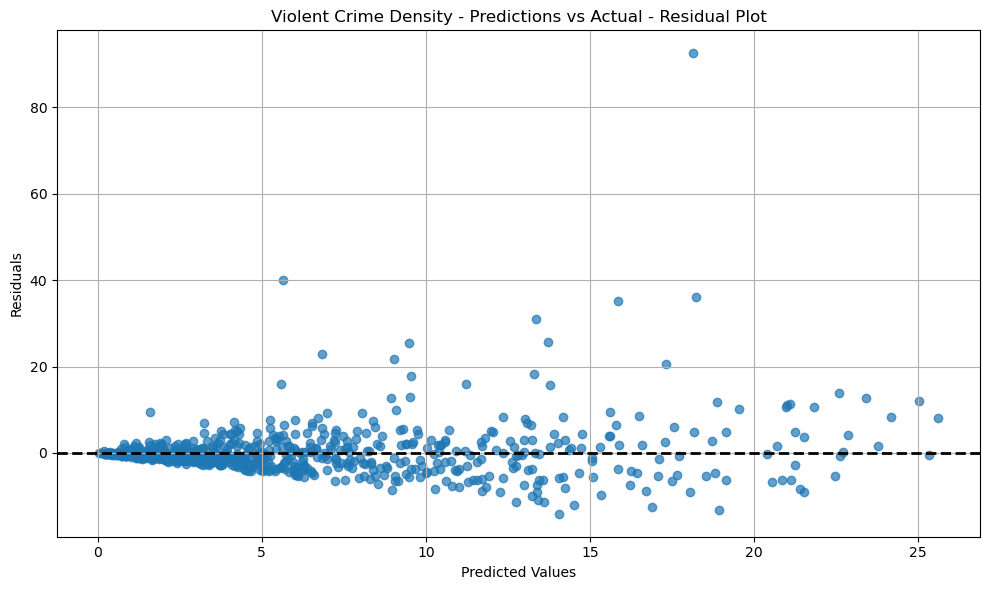

In [23]:
def plot_predictions_vs_actual(y_test, y_pred, title):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.7)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, f"{title.replace(' - ', '_').replace(' ', '_')}_predictions.png"), dpi=300)
    plt.show()

    residuals = y_test - y_pred
    plt.figure(figsize=(10, 6))
    plt.scatter(y_pred, residuals, alpha=0.7)
    plt.axhline(y=0, color='k', linestyle='--', lw=2)
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title(f"{title} - Residual Plot")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, f"{title.replace(' - ', '_').replace(' ', '_')}_residuals.png"), dpi=300)
    plt.show()


plot_predictions_vs_actual(y_total_test, total_pred, "Total Crime Density - Predictions vs Actual")
plot_predictions_vs_actual(y_property_test, property_pred, "Property Crime Density - Predictions vs Actual")
plot_predictions_vs_actual(y_violent_test, violent_pred, "Violent Crime Density - Predictions vs Actual")


## Analyze Group-Level Model Performance


Total Crime Density - Performance by station_coverage Groups:
                     Group  Count          MSE       RMSE        R²  \
0     Low station_coverage    356   374.519272  19.352500  0.565048   
1  Medium station_coverage    105  1439.953849  37.946724  0.168456   
2    High station_coverage    237  7629.958285  87.349632  0.400586   

   Mean Abs Error  
0       10.263638  
1       21.439078  
2       41.260458  


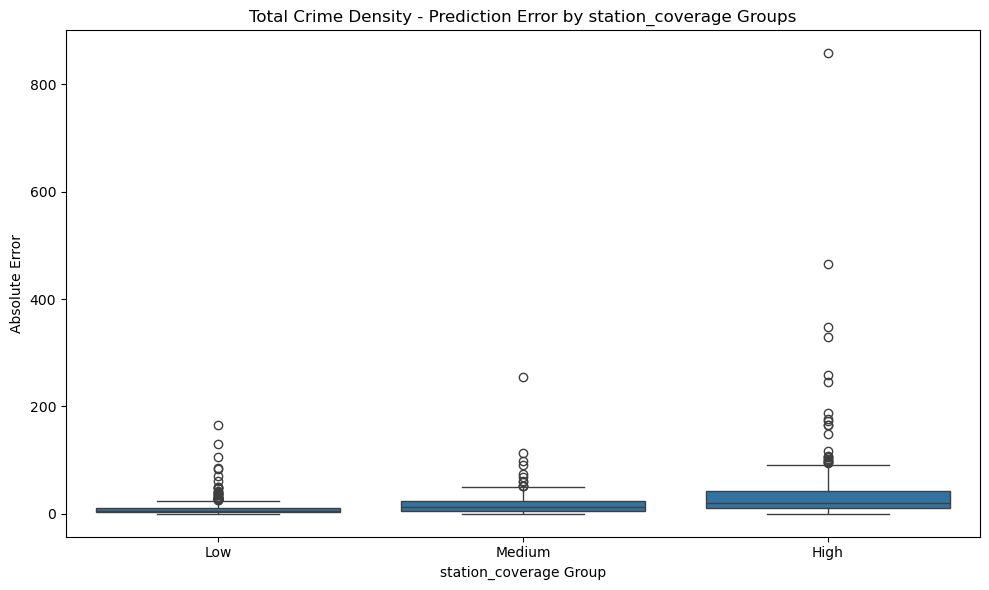


Total Crime Density - Performance by income_level Groups:
                 Group  Count          MSE       RMSE        R²  \
0     Low income_level    231  1984.728234  44.550289  0.378118   
1  Medium income_level    230  1199.810235  34.638277  0.319068   
2    High income_level    237  5731.626802  75.707508  0.527314   

   Mean Abs Error  
0       24.060432  
1       16.181529  
2       27.020992  


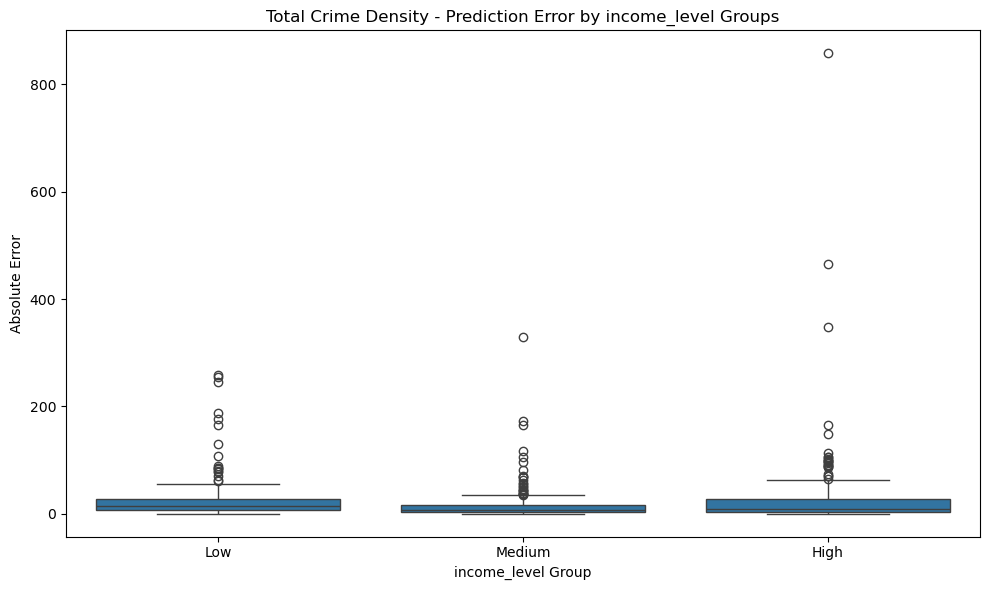


Property Crime Density - Performance by station_coverage Groups:
                     Group  Count          MSE       RMSE        R²  \
0     Low station_coverage    356   322.103100  17.947231  0.487689   
1  Medium station_coverage    105  1346.003400  36.687919  0.118112   
2    High station_coverage    237  7460.066161  86.371675  0.368290   

   Mean Abs Error  
0        9.106035  
1       19.993564  
2       39.198639  


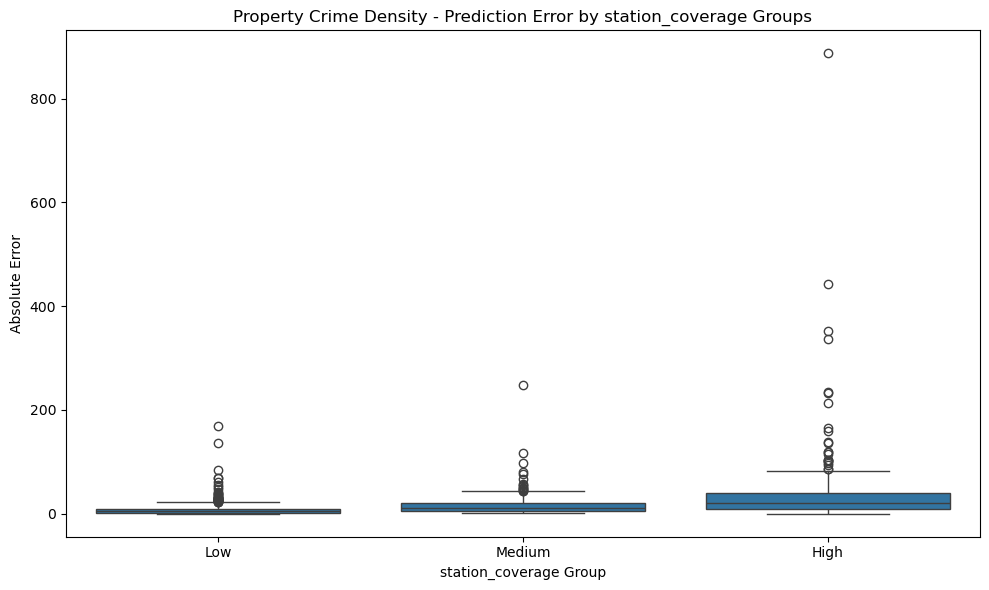


Property Crime Density - Performance by income_level Groups:
                 Group  Count          MSE       RMSE        R²  \
0     Low income_level    231  1747.162351  41.799071  0.268915   
1  Medium income_level    230  1116.871704  33.419631  0.254089   
2    High income_level    237  5753.416649  75.851280  0.494683   

   Mean Abs Error  
0       21.973020  
1       15.161891  
2       25.603998  


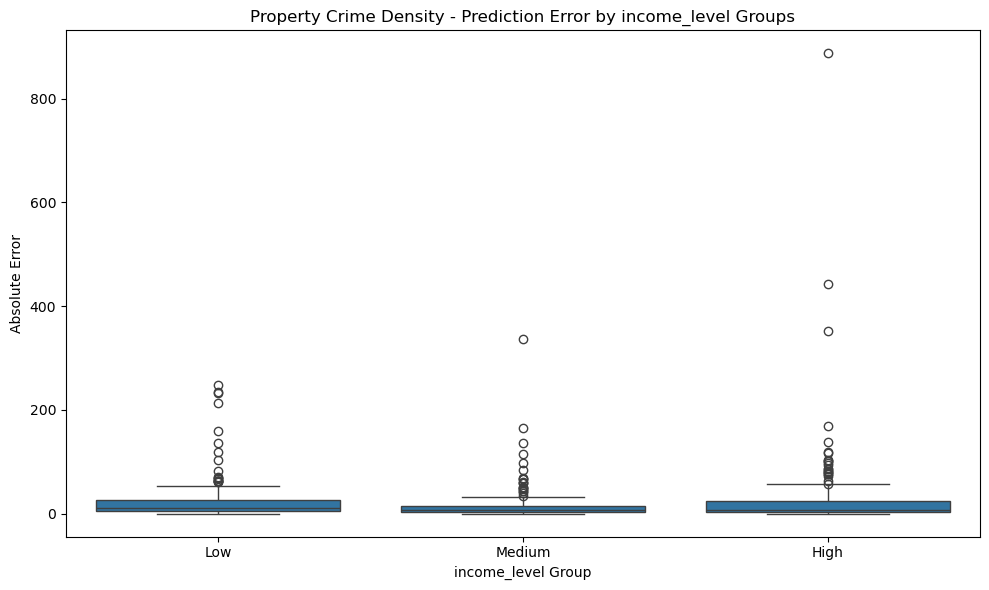


Violent Crime Density - Performance by station_coverage Groups:
                     Group  Count        MSE      RMSE        R²  \
0     Low station_coverage    356  15.136113  3.890516  0.612600   
1  Medium station_coverage    105  28.762279  5.363048  0.275643   
2    High station_coverage    237  80.208629  8.955927  0.383132   

   Mean Abs Error  
0        2.025447  
1        3.243419  
2        4.850324  


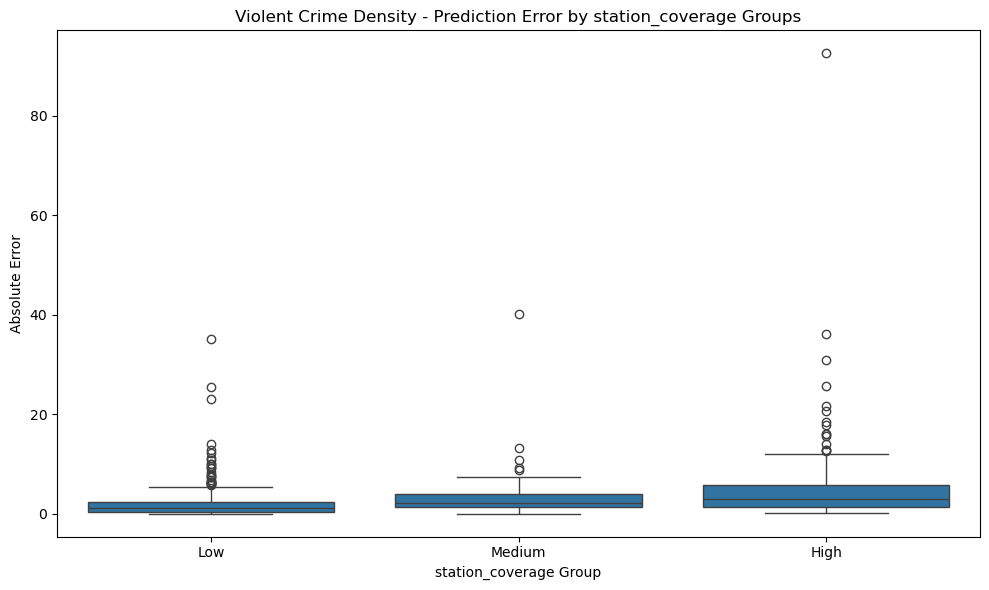


Violent Crime Density - Performance by income_level Groups:
                 Group  Count        MSE      RMSE        R²  Mean Abs Error
0     Low income_level    231  79.651963  8.924795  0.452410        4.496645
1  Medium income_level    230  22.745224  4.769195  0.373670        2.586773
2    High income_level    237  15.978632  3.997328  0.337844        2.436549


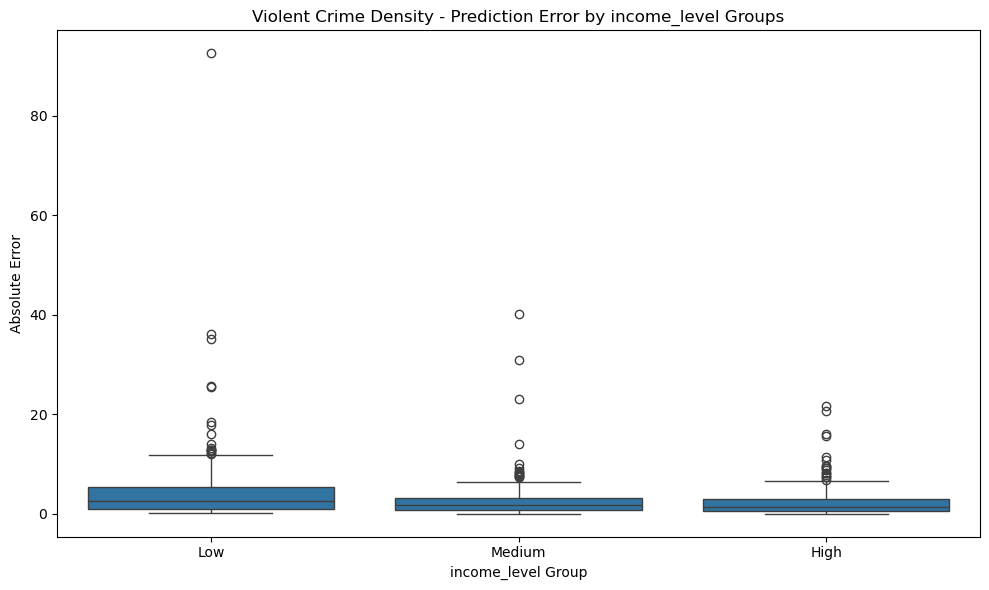

In [24]:
def group_performance_analysis(model, X_test, y_test, grouping_feature, name):
    X_test_with_target = X_test.copy()
    X_test_with_target['actual'] = y_test.values
    X_test_with_target['predicted'] = model.predict(X_test)
    X_test_with_target['error'] = abs(X_test_with_target['actual'] - X_test_with_target['predicted'])

    feature_values = df.loc[y_test.index, grouping_feature].values
    X_test_with_target['group_feature'] = feature_values

    q33 = np.percentile(feature_values, 33)
    q66 = np.percentile(feature_values, 66)

    X_test_with_target['group'] = pd.cut(
        X_test_with_target['group_feature'], 
        bins=[float('-inf'), q33, q66, float('inf')],
        labels=['Low', 'Medium', 'High']
    )

    group_results = []
    for group in ['Low', 'Medium', 'High']:
        group_data = X_test_with_target[X_test_with_target['group'] == group]
        if len(group_data) > 0:
            mse = mean_squared_error(group_data['actual'], group_data['predicted'])
            r2 = r2_score(group_data['actual'], group_data['predicted'])
            mean_error = group_data['error'].mean()

            group_results.append({
                'Group': f"{group} {grouping_feature}",
                'Count': len(group_data),
                'MSE': mse,
                'RMSE': np.sqrt(mse),
                'R²': r2,
                'Mean Abs Error': mean_error
            })

    group_df = pd.DataFrame(group_results)
    print(f"\n{name} - Performance by {grouping_feature} Groups:")
    print(group_df)

    group_df.to_csv(os.path.join(OUTPUT_DIR, f"{name}_{grouping_feature}_group_performance.csv"), index=False)

    plt.figure(figsize=(10, 6))
    sns.boxplot(x='group', y='error', data=X_test_with_target)
    plt.title(f"{name} - Prediction Error by {grouping_feature} Groups")
    plt.xlabel(f"{grouping_feature} Group")
    plt.ylabel("Absolute Error")
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, f"{name}_{grouping_feature}_group_error.png"), dpi=300)
    plt.show()


test_sets = [y_total_test, y_property_test, y_violent_test]
for name, model, y_test in zip(model_names, models, test_sets):
    group_performance_analysis(model, X_test, y_test, 'station_coverage', name)
    group_performance_analysis(model, X_test, y_test, 'income_level', name)


## Model Evaluation Summary and Save Models

In [25]:
results = []
results_df = pd.DataFrame(results)
print(results_df)

joblib.dump(total_model, os.path.join(OUTPUT_DIR, 'total_crime_rf_model.pkl'))
joblib.dump(property_model, os.path.join(OUTPUT_DIR, 'property_crime_rf_model.pkl'))
joblib.dump(violent_model, os.path.join(OUTPUT_DIR, 'violent_crime_rf_model.pkl'))
joblib.dump(scaler, os.path.join(OUTPUT_DIR, 'feature_scaler.pkl'))


Empty DataFrame
Columns: []
Index: []


['output/modeling_new/feature_scaler.pkl']

# Gaussian Process model

## Import Libraries and Read Data

In [26]:
import geopandas as gpd
import pandas as pd
from shapely import wkt

df = pd.read_csv('processed_data/ct_integrated_data.csv')
df = df.drop(columns=['Pop15t19', 'Pop20t24', 'Pop25t29'])


## Extract Centroid Coordinates from Geometry Column

In [27]:
def extract_centroids_from_geometry(df):
    """Extract centroid coordinates from the geometry column of a DataFrame"""
    if 'geometry' not in df.columns:
        print("Geometry column not found in DataFrame")
        return df
    
    try:
        import shapely.wkt

        centroids = []
        
        for geom_str in df['geometry']:
            try:
                geom = shapely.wkt.loads(geom_str)
                centroid = geom.centroid
                centroids.append((centroid.x, centroid.y))
            except Exception as e:
                print(f"Error processing geometry object: {e}")
                centroids.append((np.nan, np.nan))
        
        df['centroid_x'] = [c[0] for c in centroids]
        df['centroid_y'] = [c[1] for c in centroids]
        
        nan_count = df['centroid_x'].isna().sum()
        if nan_count > 0:
            print(f"Warning: {nan_count} NaN values in extracted centroids")
            mean_x = df['centroid_x'].mean()
            mean_y = df['centroid_y'].mean()
            df['centroid_x'] = df['centroid_x'].fillna(mean_x)
            df['centroid_y'] = df['centroid_y'].fillna(mean_y)
        
        return df
    
    except ImportError:
        print("Could not import shapely library. Trying alternative methods to extract coordinates...")
        
        try:
            centroids = []
            for geom_str in df['geometry']:
                try:
                    if "POINT" in geom_str:
                        coords = geom_str.replace("POINT(", "").replace(")", "").split()
                        centroids.append((float(coords[0]), float(coords[1])))
                    elif "POLYGON" in geom_str or "MULTIPOLYGON" in geom_str:
                        coords_part = geom_str.split("((")[1].split(",")[0].split()
                        centroids.append((float(coords_part[0]), float(coords_part[1])))
                    else:
                        centroids.append((np.nan, np.nan))
                except Exception:
                    centroids.append((np.nan, np.nan))
            
            df['centroid_x'] = [c[0] for c in centroids]
            df['centroid_y'] = [c[1] for c in centroids]
            
            nan_count = df['centroid_x'].isna().sum()
            if nan_count > 0:
                print(f"Warning: {nan_count} NaN values in extracted centroids")
                np.random.seed(42)
                for i in df.index[df['centroid_x'].isna()]:
                    df.loc[i, 'centroid_x'] = np.random.uniform(0, 100)
                    df.loc[i, 'centroid_y'] = np.random.uniform(0, 100)
            
            return df
        
        except Exception as e:
            print(f"Error extracting coordinates: {e}")
            print("Using random coordinates as fallback")
            
            np.random.seed(42)
            df['centroid_x'] = np.random.uniform(0, 100, size=len(df))
            df['centroid_y'] = np.random.uniform(0, 100, size=len(df))
            return df

In [28]:
def preprocess_features_for_gp(X_train, X_test, y_train, max_features=10):
    """Preprocess features for Gaussian Process model, including feature selection and standardization"""
    from sklearn.feature_selection import SelectKBest, f_regression
    from sklearn.preprocessing import StandardScaler
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    selector = SelectKBest(f_regression, k=max_features)
    X_train_selected = selector.fit_transform(X_train_scaled, y_train)
    X_test_selected = selector.transform(X_test_scaled)
    
    selected_indices = selector.get_support(indices=True)
    
    return X_train_selected, X_test_selected, selected_indices

## Gaussian Process (GP) Model Analysis for Spatial Correlation

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, Matern, RationalQuadratic
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold
from sklearn.impute import SimpleImputer
from scipy.spatial.distance import cdist
import scipy.stats as stats
import os

## Prepare Data and Extract Centroids for Gaussian Process Modeling

In [30]:
GP_OUTPUT_DIR = os.path.join(OUTPUT_DIR, "gaussian_process")
os.makedirs(GP_OUTPUT_DIR, exist_ok=True)

print("Extracting centroid coordinates from geometry data...")
df = extract_centroids_from_geometry(df)

X_train_values = X_train.values
X_test_values = X_test.values
y_total_train_values = y_total_train.values
y_total_test_values = y_total_test.values
y_property_train_values = y_property_train.values
y_property_test_values = y_property_test.values
y_violent_train_values = y_violent_train.values
y_violent_test_values = y_violent_test.values

print(f"Number of NaN values in X_train: {np.isnan(X_train_values).sum()}")
print(f"Number of NaN values in X_test: {np.isnan(X_test_values).sum()}")


Extracting centroid coordinates from geometry data...
Number of NaN values in X_train: 0
Number of NaN values in X_test: 0


In [31]:
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train_values)
X_test_imputed = imputer.transform(X_test_values)

print(f"Number of NaN values in X_train after imputation: {np.isnan(X_train_imputed).sum()}")
print(f"Number of NaN values in X_test after imputation: {np.isnan(X_test_imputed).sum()}")

for name, y_train, y_test in zip(
    ['Total Crime', 'Property Crime', 'Violent Crime'],
    [y_total_train_values, y_property_train_values, y_violent_train_values],
    [y_total_test_values, y_property_test_values, y_violent_test_values]
):
    print(f"Number of NaN values in {name} training set: {np.isnan(y_train).sum()}")
    print(f"Number of NaN values in {name} test set: {np.isnan(y_test).sum()}")


Number of NaN values in X_train after imputation: 0
Number of NaN values in X_test after imputation: 0
Number of NaN values in Total Crime training set: 0
Number of NaN values in Total Crime test set: 0
Number of NaN values in Property Crime training set: 0
Number of NaN values in Property Crime test set: 0
Number of NaN values in Violent Crime training set: 0
Number of NaN values in Violent Crime test set: 0


In [32]:
y_total_train_imputed = np.nan_to_num(y_total_train_values, nan=np.nanmean(y_total_train_values))
y_total_test_imputed = np.nan_to_num(y_total_test_values, nan=np.nanmean(y_total_test_values))
y_property_train_imputed = np.nan_to_num(y_property_train_values, nan=np.nanmean(y_property_train_values))
y_property_test_imputed = np.nan_to_num(y_property_test_values, nan=np.nanmean(y_property_test_values))
y_violent_train_imputed = np.nan_to_num(y_violent_train_values, nan=np.nanmean(y_violent_train_values))
y_violent_test_imputed = np.nan_to_num(y_violent_test_values, nan=np.nanmean(y_violent_test_values))

train_indices = X_train.index.tolist()
test_indices = X_test.index.tolist()

X_train_coords = np.array([[df['centroid_x'].iloc[i], df['centroid_y'].iloc[i]] for i in train_indices])
X_test_coords = np.array([[df['centroid_x'].iloc[i], df['centroid_y'].iloc[i]] for i in test_indices])

print(f"Training set shape: {X_train_imputed.shape}, Test set shape: {X_test_imputed.shape}")


Training set shape: (1627, 21), Test set shape: (698, 21)


## Train Gaussian Process Model with Multiple Kernels and Cross-Validation


In [33]:
def fit_gp_model_improved(X_train_imputed, y_train_imputed, title):
    """Improved Gaussian Process model training function"""

    kernels = {
        'RBF': 1.0 * RBF(length_scale=[1.0] * X_train_imputed.shape[1], 
                         length_scale_bounds=(0.1, 100.0)) + WhiteKernel(noise_level=1.0, 
                                                                          noise_level_bounds=(0.1, 100.0)),
        'Matern': 1.0 * Matern(length_scale=[1.0] * X_train_imputed.shape[1], 
                                nu=1.5, 
                                length_scale_bounds=(0.1, 100.0)) + WhiteKernel(noise_level=1.0, 
                                                                                 noise_level_bounds=(0.1, 100.0)),
        'RationalQuadratic': 1.0 * RationalQuadratic(length_scale=1.0, 
                                                     alpha=0.1, 
                                                     length_scale_bounds=(0.1, 100.0),
                                                     alpha_bounds=(0.01, 10.0)) + WhiteKernel(noise_level=1.0, 
                                                                                              noise_level_bounds=(0.1, 100.0))
    }
    
    best_model = None
    best_score = -float('inf')
    best_kernel_name = None
    
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    for kernel_name, kernel in kernels.items():
        print(f"\nTrying {kernel_name} kernel...")
        
        cv_scores = []
        
        for train_idx, val_idx in kf.split(X_train_imputed):

            X_fold_train, X_fold_val = X_train_imputed[train_idx], X_train_imputed[val_idx]
            y_fold_train, y_fold_val = y_train_imputed[train_idx], y_train_imputed[val_idx]

            gp = GaussianProcessRegressor(
                kernel=kernel,
                n_restarts_optimizer=3, 
                random_state=42,
                normalize_y=True  
            )
            
            try:
                gp.fit(X_fold_train, y_fold_train)
                y_fold_pred = gp.predict(X_fold_val)
                fold_r2 = r2_score(y_fold_val, y_fold_pred)
                cv_scores.append(fold_r2)
            except Exception as e:
                print(f"  Fold {len(cv_scores)+1} error: {e}")
                cv_scores.append(-float('inf'))
        
        mean_cv_score = np.mean([s for s in cv_scores if s != -float('inf')])
        if len([s for s in cv_scores if s != -float('inf')]) == 0:
            mean_cv_score = -float('inf')
        
        print(f"{kernel_name} cross-validation R²: {mean_cv_score:.4f}")
        
        if mean_cv_score > best_score:
            best_score = mean_cv_score
            best_kernel_name = kernel_name
            
            final_gp = GaussianProcessRegressor(
                kernel=kernel,
                n_restarts_optimizer=5,
                random_state=42,
                normalize_y=True
            )
            try:
                final_gp.fit(X_train_imputed, y_train_imputed)
                best_model = final_gp
            except Exception as e:
                print(f"Final model training failed: {e}")
    
    if best_model is not None:
        print(f"\nBest kernel: {best_kernel_name}, cross-validation R²: {best_score:.4f}")
        print(f"Optimized kernel parameters: {best_model.kernel_}")
        
        params_reasonable = True
        if best_kernel_name == "RationalQuadratic":
            try:
                length_scale = best_model.kernel_.k1.length_scale
                alpha = best_model.kernel_.k1.alpha
                noise_level = best_model.kernel_.k2.noise_level
                
                if length_scale > 1000 or noise_level > 1000:
                    params_reasonable = False
                    print(f"Warning: Optimized parameters are unreasonable (length_scale={length_scale}, noise_level={noise_level})")
                    print("Trying second best kernel...")
            except:
                print("Unable to parse kernel parameters")
        
        if not params_reasonable:
            backup_kernel = 1.0 * Matern(length_scale=1.0, nu=1.5) + WhiteKernel(noise_level=1.0)
            backup_model = GaussianProcessRegressor(
                kernel=backup_kernel,
                n_restarts_optimizer=5,
                random_state=42,
                normalize_y=True
            )
            backup_model.fit(X_train_imputed, y_train_imputed)
            best_model = backup_model
            print(f"Using backup model. New kernel parameters: {best_model.kernel_}")
        
        with open(os.path.join(GP_OUTPUT_DIR, f"{title.replace(' ', '_')}_model_info.txt"), 'w') as f:
            f.write(f"Best kernel: {best_kernel_name}\n")
            f.write(f"Cross-validation R²: {best_score:.4f}\n")
            f.write(f"Optimized kernel parameters: {best_model.kernel_}\n")
    else:
        print(f"Warning: No successful model for {title}. Using default RBF kernel.")
        best_model = GaussianProcessRegressor(
            kernel=1.0 * RBF(length_scale=1.0) + WhiteKernel(noise_level=1.0),
            random_state=42,
            normalize_y=True
        )
        try:
            best_model.fit(X_train_imputed, y_train_imputed)
        except Exception as e:
            print(f"Unable to train default model: {e}")
    
    return best_model

## Evaluate Gaussian Process Model and Visualize Predictions


In [34]:
def evaluate_gp_model(model, X_test_imputed, y_test_imputed, X_test_vis_coords, title):
    """Evaluate Gaussian Process model and return predictions and uncertainty"""
    if model is None:
        print(f"Model is None, cannot evaluate {title}")
        return None, None
    
    try:
        y_pred, y_std = model.predict(X_test_imputed, return_std=True)
        
        mse = mean_squared_error(y_test_imputed, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test_imputed, y_pred)
        
        print(f"\n{title} evaluation results:")
        print(f"MSE: {mse:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}")
        
        plt.figure(figsize=(10, 6))
        plt.scatter(y_test_imputed, y_pred, alpha=0.7)
        plt.plot([min(y_test_imputed), max(y_test_imputed)], [min(y_test_imputed), max(y_test_imputed)], 'k--', lw=2)
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.title(f"{title} - Gaussian Process Model Predictions vs Actual Values")
        plt.grid(True)
        plt.savefig(os.path.join(GP_OUTPUT_DIR, f"{title.replace(' ', '_')}_predictions.png"), dpi=300)
        plt.close()
        
        return y_pred, y_std
    except Exception as e:
        print(f"Error evaluating Gaussian Process model for {title}: {e}")
        return None, None

## Visualize Spatial Predictions, Errors, and Uncertainty


In [35]:
def visualize_spatial_predictions(X_test_vis_coords, y_test_imputed, y_pred, y_std, title):
    """Visualize spatial prediction results and uncertainty using coordinates"""
    if y_pred is None or y_std is None:
        print(f"Prediction results are None, cannot visualize spatial predictions for {title}")
        return None
    
    try:
        error = np.abs(y_test_imputed - y_pred)
        
        plt.figure(figsize=(14, 10))
        
        plt.subplot(2, 2, 1)
        sc = plt.scatter(X_test_vis_coords[:, 0], X_test_vis_coords[:, 1], 
                  c=y_test_imputed, cmap='viridis', 
                  s=50, alpha=0.8)
        plt.colorbar(sc, label='Actual Crime Density')
        plt.title("Spatial Distribution of Actual Crime Density")
        plt.xlabel("X Coordinate")
        plt.ylabel("Y Coordinate")
        
        plt.subplot(2, 2, 2)
        sc = plt.scatter(X_test_vis_coords[:, 0], X_test_vis_coords[:, 1], 
                  c=y_pred, cmap='viridis', 
                  s=50, alpha=0.8)
        plt.colorbar(sc, label='Predicted Crime Density')
        plt.title("Spatial Distribution of Predicted Crime Density")
        plt.xlabel("X Coordinate")
        plt.ylabel("Y Coordinate")
        
        plt.subplot(2, 2, 3)
        sc = plt.scatter(X_test_vis_coords[:, 0], X_test_vis_coords[:, 1], 
                  c=error, cmap='Reds', 
                  s=50, alpha=0.8)
        plt.colorbar(sc, label='Prediction Error')
        plt.title("Spatial Distribution of Prediction Error")
        plt.xlabel("X Coordinate")
        plt.ylabel("Y Coordinate")
        
        plt.subplot(2, 2, 4)
        sc = plt.scatter(X_test_vis_coords[:, 0], X_test_vis_coords[:, 1], 
                  c=y_std, cmap='Blues', 
                  s=50, alpha=0.8)
        plt.colorbar(sc, label='Prediction Standard Deviation')
        plt.title("Spatial Distribution of Prediction Uncertainty")
        plt.xlabel("X Coordinate")
        plt.ylabel("Y Coordinate")
        
        plt.tight_layout()
        plt.savefig(os.path.join(GP_OUTPUT_DIR, f"{title.replace(' ', '_')}_spatial_predictions.png"), dpi=300)
        plt.close()
        
        results = np.column_stack((X_test_vis_coords, y_test_imputed, y_pred, y_std, error))
        
        result_df = pd.DataFrame(
            results,
            columns=['x', 'y', 'actual', 'predicted', 'std', 'error']
        )
        result_df.to_csv(os.path.join(GP_OUTPUT_DIR, f"{title.replace(' ', '_')}_spatial_results.csv"), index=False)
        
        return result_df
    except Exception as e:
        print(f"Error visualizing spatial predictions for {title}: {e}")
        return None

## Analyze Spatial Autocorrelation of Crime and Prediction Errors


In [36]:
def analyze_spatial_autocorrelation(spatial_results, title):
    """Analyze spatial autocorrelation"""
    if spatial_results is None:
        print(f"Spatial results are None, cannot analyze spatial autocorrelation for {title}")
        return
    
    try:
        coords = spatial_results[['x', 'y']].values
        
        dist_matrix = cdist(coords, coords)
        
        K = min(5, len(spatial_results)-1)  
        nearest_indices = np.argsort(dist_matrix, axis=1)[:, 1:K+1]  
        
        actual_values = spatial_results['actual'].values
        actual_spatial_corr = []
        
        for i in range(len(spatial_results)):

            current_value = actual_values[i]
            
            neighbor_values = actual_values[nearest_indices[i]]

            neighbor_avg = np.mean(neighbor_values)
            actual_spatial_corr.append((current_value, neighbor_avg))
        
        actual_spatial_corr = np.array(actual_spatial_corr)
        
        residuals = spatial_results['error'].values
        residual_spatial_corr = []
        
        for i in range(len(spatial_results)):
            current_residual = residuals[i]
            neighbor_residuals = residuals[nearest_indices[i]]
            neighbor_avg = np.mean(neighbor_residuals)
            residual_spatial_corr.append((current_residual, neighbor_avg))
        
        residual_spatial_corr = np.array(residual_spatial_corr)
        
        actual_corr, _ = stats.pearsonr(actual_spatial_corr[:, 0], actual_spatial_corr[:, 1])
        residual_corr, _ = stats.pearsonr(residual_spatial_corr[:, 0], residual_spatial_corr[:, 1])
        
        print(f"\nSpatial autocorrelation analysis results:")
        print(f"Spatial autocorrelation of actual crime density (approx. Moran's I): {actual_corr:.4f}")
        print(f"Spatial autocorrelation of residuals (approx. Moran's I): {residual_corr:.4f}")
        
        with open(os.path.join(GP_OUTPUT_DIR, f"{title.replace(' ', '_')}_spatial_autocorr.txt"), 'w') as f:
            f.write(f"Spatial autocorrelation of actual crime density (approx. Moran's I): {actual_corr:.4f}\n")
            f.write(f"Spatial autocorrelation of residuals (approx. Moran's I): {residual_corr:.4f}\n")
        
        plt.figure(figsize=(12, 6))
        
        plt.subplot(1, 2, 1)
        plt.scatter(actual_spatial_corr[:, 0], actual_spatial_corr[:, 1], alpha=0.6)
        plt.plot(np.unique(actual_spatial_corr[:, 0]), 
                 np.poly1d(np.polyfit(actual_spatial_corr[:, 0], actual_spatial_corr[:, 1], 1))(np.unique(actual_spatial_corr[:, 0])), 
                 'r--')
        plt.xlabel('Current Location Crime Density')
        plt.ylabel('Average Crime Density in Nearby Locations')
        plt.title(f'Spatial Autocorrelation of Actual Crime Density\nMoran\'s I ≈ {actual_corr:.4f}')
        
        plt.subplot(1, 2, 2)
        plt.scatter(residual_spatial_corr[:, 0], residual_spatial_corr[:, 1], alpha=0.6)
        plt.plot(np.unique(residual_spatial_corr[:, 0]), 
                 np.poly1d(np.polyfit(residual_spatial_corr[:, 0], residual_spatial_corr[:, 1], 1))(np.unique(residual_spatial_corr[:, 0])), 
                 'r--')
        plt.xlabel('Current Location Prediction Error')
        plt.ylabel('Average Prediction Error in Nearby Locations')
        plt.title(f'Spatial Autocorrelation of Prediction Errors\nMoran\'s I ≈ {residual_corr:.4f}')
        
        plt.tight_layout()
        plt.savefig(os.path.join(GP_OUTPUT_DIR, f"{title.replace(' ', '_')}_spatial_autocorr.png"), dpi=300)
        plt.close()
    except Exception as e:
        print(f"Error analyzing spatial autocorrelation for {title}: {e}")


## Compare Performance of Random Forest and Gaussian Process Models


In [37]:
def compare_rf_gp_models(rf_pred, gp_pred, y_test_imputed, title):
    """Compare Random Forest and Gaussian Process model performance"""
    if gp_pred is None:
        print(f"Gaussian Process prediction results are None, cannot compare model performance for {title}")
        return
    
    try:
        rf_mse = mean_squared_error(y_test_imputed, rf_pred)
        rf_r2 = r2_score(y_test_imputed, rf_pred)
        
        gp_mse = mean_squared_error(y_test_imputed, gp_pred)
        gp_r2 = r2_score(y_test_imputed, gp_pred)
        
        model_comparison = pd.DataFrame({
            'Model': ['Random Forest', 'Gaussian Process'],
            'MSE': [rf_mse, gp_mse],
            'RMSE': [np.sqrt(rf_mse), np.sqrt(gp_mse)],
            'R²': [rf_r2, gp_r2]
        })
        
        print(f"\n{title} - Model Comparison:")
        print(model_comparison)
        
        model_comparison.to_csv(os.path.join(GP_OUTPUT_DIR, f"{title.replace(' ', '_')}_model_comparison.csv"), index=False)
        
        plt.figure(figsize=(12, 10))
        
        plt.subplot(2, 2, 1)
        plt.scatter(y_test_imputed, rf_pred, alpha=0.7)
        plt.plot([min(y_test_imputed), max(y_test_imputed)], [min(y_test_imputed), max(y_test_imputed)], 'k--', lw=2)
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.title(f"Random Forest Predictions (R² = {rf_r2:.4f})")
        
        plt.subplot(2, 2, 2)
        plt.scatter(y_test_imputed, gp_pred, alpha=0.7)
        plt.plot([min(y_test_imputed), max(y_test_imputed)], [min(y_test_imputed), max(y_test_imputed)], 'k--', lw=2)
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.title(f"Gaussian Process Predictions (R² = {gp_r2:.4f})")
        
        plt.subplot(2, 2, 3)
        rf_residuals = y_test_imputed - rf_pred
        plt.scatter(rf_pred, rf_residuals, alpha=0.7)
        plt.axhline(y=0, color='k', linestyle='--', lw=2)
        plt.xlabel('Predicted Values')
        plt.ylabel('Residuals')
        plt.title("Random Forest Residuals")
        
        plt.subplot(2, 2, 4)
        gp_residuals = y_test_imputed - gp_pred
        plt.scatter(gp_pred, gp_residuals, alpha=0.7)
        plt.axhline(y=0, color='k', linestyle='--', lw=2)
        plt.xlabel('Predicted Values')
        plt.ylabel('Residuals')
        plt.title("Gaussian Process Residuals")
        
        plt.tight_layout()
        plt.savefig(os.path.join(GP_OUTPUT_DIR, f"{title.replace(' ', '_')}_model_comparison.png"), dpi=300)
        plt.close()
        
        plt.figure(figsize=(10, 6))
        sns.kdeplot(rf_residuals, label='Random Forest Residuals')
        sns.kdeplot(gp_residuals, label='Gaussian Process Residuals')
        plt.xlabel('Residuals')
        plt.ylabel('Density')
        plt.title(f"{title} - Residual Distribution Comparison")
        plt.legend()
        plt.grid(True)
        plt.savefig(os.path.join(GP_OUTPUT_DIR, f"{title.replace(' ', '_')}_residual_comparison.png"), dpi=300)
        plt.close()
        
        return model_comparison
    except Exception as e:
        print(f"Error comparing model performance for {title}: {e}")
        return None

## Estimate Feature Importance in Gaussian Process Model


In [38]:
def analyze_feature_importance(model, X_test_imputed, feature_names, title):
    """Attempt to analyze feature importance in Gaussian Process model through partial dependence"""
    try:
        feature_effects = []
        
        for i, feature_name in enumerate(feature_names):
            feature_values = np.linspace(
                np.min(X_test_imputed[:, i]),
                np.max(X_test_imputed[:, i]),
                num=20
            )
            
            mean_predictions = []
            for val in feature_values:
                X_modified = X_test_imputed.copy()
                X_modified[:, i] = val
                
                predictions = model.predict(X_modified)
                mean_prediction = np.mean(predictions)
                mean_predictions.append(mean_prediction)
        
            impact_range = max(mean_predictions) - min(mean_predictions)
            feature_effects.append((feature_name, impact_range))
        
        feature_effects.sort(key=lambda x: x[1], reverse=True)
        
        plt.figure(figsize=(12, 8))
        features, impacts = zip(*feature_effects)
        plt.barh(range(len(features)), impacts, align='center')
        plt.yticks(range(len(features)), features)
        plt.xlabel('Feature Impact (Range of Mean Predictions)')
        plt.title(f"{title} - Approximate Feature Importance in Gaussian Process Model")
        plt.tight_layout()
        plt.savefig(os.path.join(GP_OUTPUT_DIR, f"{title.replace(' ', '_')}_feature_importance.png"), dpi=300)
        plt.close()
        
        with open(os.path.join(GP_OUTPUT_DIR, f"{title.replace(' ', '_')}_feature_importance.txt"), 'w') as f:
            for feature, impact in feature_effects:
                f.write(f"{feature}: {impact:.4f}\n")
        
        return feature_effects
    except Exception as e:
        print(f"Error analyzing feature importance for {title}: {e}")
        return None

## Execute and Summarize Gaussian Process Analysis


In [39]:
model_names = ['Total Crime Density', 'Property Crime Density', 'Violent Crime Density']
y_test_imputed_list = [y_total_test_imputed, y_property_test_imputed, y_violent_test_imputed]
y_train_imputed_list = [y_total_train_imputed, y_property_train_imputed, y_violent_train_imputed]
rf_predictions = [total_pred, property_pred, violent_pred]

for i, (name, y_train_imputed, y_test_imputed, rf_pred) in enumerate(zip(model_names, y_train_imputed_list, y_test_imputed_list, rf_predictions)):
    print(f"\n\n===== Starting Gaussian Process Model Analysis for {name} =====")
    
    try:
        X_train_gp, X_test_gp, selected_indices = preprocess_features_for_gp(
            X_train_imputed, X_test_imputed, y_train_imputed, max_features=10
        )
        
        selected_features = [features[idx] for idx in selected_indices]
        print(f"Features selected for Gaussian Process model: {selected_features}")
        
        gp_model = fit_gp_model_improved(X_train_gp, y_train_imputed, name)
        
        gp_pred, gp_std = evaluate_gp_model(gp_model, X_test_gp, y_test_imputed, X_test_coords, name)
        
        analyze_feature_importance(gp_model, X_test_gp, selected_features, name)
        
        spatial_results = visualize_spatial_predictions(X_test_coords, y_test_imputed, gp_pred, gp_std, name)
        
        analyze_spatial_autocorrelation(spatial_results, name)
        
        compare_rf_gp_models(rf_pred, gp_pred, y_test_imputed, name)
        
    except Exception as e:
        print(f"Error in Gaussian Process model analysis process for {name}: {e}")

print("\n\n===== Gaussian Process Model Analysis Summary =====")
print("1. Gaussian Process models can explicitly quantify prediction uncertainty, which Random Forest models cannot")
print("2. Gaussian Process models sometimes capture relationships that Random Forest models cannot")
print("3. Spatial autocorrelation analysis reveals the spatial structure of crime data and evaluates the model's ability to capture this structure")
print("4. Feature importance analysis helps understand which variables are most significant in driving crime patterns")
print(f"5. All analysis results have been saved to the {GP_OUTPUT_DIR} directory")



===== Starting Gaussian Process Model Analysis for Total Crime Density =====
Features selected for Gaussian Process model: ['station_density', 'station_coverage', 'avg_ridership', 'transfer_station_ratio', 'avg_entrances', 'population_density', 'neighboring_crime_density', 'poi_density_Religious Institution', 'poi_density_Cultural Facility', 'poi_density_Commercial']

Trying RBF kernel...
RBF cross-validation R²: 0.1549

Trying Matern kernel...
Matern cross-validation R²: 0.2561

Trying RationalQuadratic kernel...
RationalQuadratic cross-validation R²: 0.4198

Best kernel: RationalQuadratic, cross-validation R²: 0.4198
Optimized kernel parameters: 7.05**2 * RationalQuadratic(alpha=0.0116, length_scale=4.77) + WhiteKernel(noise_level=0.1)
Unable to parse kernel parameters

Total Crime Density evaluation results:
MSE: 3100.3677, RMSE: 55.6809, R²: 0.4683

Spatial autocorrelation analysis results:
Spatial autocorrelation of actual crime density (approx. Moran's I): 0.4241
Spatial autoco